#DOWLOADING LIBRARIES

In [1]:
pip install requests beautifulsoup4 selenium pandas yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 8.5 MB/s eta 0:00:00


In [3]:
!pip install webdriver-manager

In [ ]:
!apt-get update
!apt install chromium-chromedriver

#SCRAPING

In [105]:
import pandas as pd
import os
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

os.environ["PATH"] += ":/usr/bin/"

options = Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36')

driver = webdriver.Chrome(options=options)

url = "https://www.nseindia.com/market-data/live-equity-market"
driver.get(url)

def wait_for_element(xpath, timeout=20):
    """Wait for an element to be present on the page."""
    return WebDriverWait(driver, timeout).until(
        EC.visibility_of_element_located((By.XPATH, xpath))
    )

def get_nifty_table():
    """Get the Nifty50 table from the website."""
    try:
        WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.XPATH, "//table[@id='equityStockTable']//tbody/tr[1]"))
        )
        table = wait_for_element("//table[@id='equityStockTable']")
        return table
    except Exception as e:
        print(f"Error while getting the table: {e}")
        return None

def get_first_row_data():
    """Extract data from the first row of the Nifty50 stock table."""
    try:
        table = get_nifty_table()

        if table is None:
            raise Exception("Failed to find the table")

        header_row = table.find_element(By.XPATH, ".//thead/tr")
        column_names = [th.text.strip() for th in header_row.find_elements(By.TAG_NAME, "th")][0:-1]

        column_names += ['PE','MARKET_CAP']
        row = table.find_element(By.XPATH, ".//tbody/tr[1]")

        row_data = [cell.text.strip() for cell in row.find_elements(By.TAG_NAME, "td")][0:-5]
        if not any(row_data):
            print("First row contains no valid data.")
            return None
        if len(row_data) == len(column_names) - 2:
            row_data += ["N/A", "N/A"]
        df = pd.DataFrame([row_data], columns=column_names)

        return df

    except Exception as e:
        print(f"Error while scraping the table: {e}")
        return None

def get_additional_stock_data(symbol):
    """Navigate to the stock's individual page and scrape additional details like PE, EPS."""
    try:
        stock_url = f"https://www.screener.in/company/NIFTY/"
        driver.get(stock_url)
        cap = wait_for_element("//li[@class='flex flex-space-between' and .//span[text()='Market Cap']]//span[@class='nowrap value']//span[@class='number']").text
        pe = wait_for_element("//li[@class='flex flex-space-between' and .//span[text()='P/E']]//span[@class='nowrap value']//span[@class='number']").text

        return pe, cap
    except Exception as e:
        print(f"Error fetching additional data for {symbol}: {e}")
        return "N/A", "N/A"

def main():
    retries = 3
    while retries > 0:
        try:
            df = get_first_row_data()
            if df is not None:
                symbol = df['SYMBOL'].iloc[0]
                pe, cap = get_additional_stock_data(symbol)
                df.at[0, 'PE'] = pe
                df.at[0, 'MARKET_CAP'] = cap

                print(df)
                break
        except Exception as e:
            print(f"Error during scraping process: {e}")
            retries -= 1
            if retries > 0:
                print("Retrying...")
                time.sleep(5)
            else:
                print("Max retries reached. Exiting.")
                break

if __name__ == "__main__":
    main()

driver.quit()


Error fetching additional data for NIFTY 50: Message: 
Stacktrace:
#0 0x5af67714631a <unknown>
#1 0x5af676c5c6e0 <unknown>
#2 0x5af676cab3e6 <unknown>
#3 0x5af676cab681 <unknown>
#4 0x5af676cf0b04 <unknown>
#5 0x5af676ccf48d <unknown>
#6 0x5af676ceded7 <unknown>
#7 0x5af676ccf203 <unknown>
#8 0x5af676c9dcc0 <unknown>
#9 0x5af676c9ec9e <unknown>
#10 0x5af677113d0b <unknown>
#11 0x5af677117c92 <unknown>
#12 0x5af677100b3c <unknown>
#13 0x5af677118807 <unknown>
#14 0x5af6770e60df <unknown>
#15 0x5af677135578 <unknown>
#16 0x5af677135740 <unknown>
#17 0x5af677145196 <unknown>
#18 0x7c1fc1a80ac3 <unknown>

     SYMBOL       OPEN       HIGH        LOW PREV. CLOSE        LTP  \
0  NIFTY 50  24,498.35  24,792.30  24,180.80   24,548.70  24,768.30   

  INDICATIVE CLOSE    CHNG %CHNG VOLUME\n(shares) VALUE\n(₹ Crores)  \
0                -  219.60  0.89     31,00,80,852         30,429.59   

       52W H      52W L 30 D\n%CHNG   PE MARKET_CAP  
0  26,277.35  21,137.20        3.70  N/A        N/A

In [102]:
df

,SYMBOL,OPEN,HIGH,LOW,PREV. CLOSE,LTP,INDICATIVE CLOSE,CHNG,%CHNG,VOLUME\n(shares),VALUE\n(₹ Crores),52W H,52W L,30 D\n%CHNG
0,NIFTY 50,"24,498.35","24,792.30","24,180.80","24,548.70","24,768.30",-,219.60,0.89,"31,00,80,852","30,429.59","26,277.35","21,137.20",3.70


#YFINANCE

In [ ]:
tickers = [
    "ADANIGREEN.NS",
    "ADANIPORTS.NS",
    "APOLLOHOSP.NS",
    "ASIANPAINT.NS",
    "AXISBANK.NS",
    "BAJAJ-AUTO.NS",
    "BAJFINANCE.NS",
    "BAJAJFINSV.NS",
    "BEL.NS",
    "BHARTIARTL.NS",
    "BPCL.NS",
    "CIPLA.NS",
    "COALINDIA.NS",
    "DRREDDY.NS",
    "EICHERMOT.NS",
    "GRASIM.NS",
    "HCLTECH.NS",
    "HDFCBANK.NS",
    "HDFCLIFE.NS",
    "HEROMOTOCO.NS",
    "HINDALCO.NS",
    "HINDUNILVR.NS",
    "ICICIBANK.NS",
    "INDUSINDBK.NS",
    "INFY.NS",
    "IOC.NS",
    "ITC.NS",
    "JSWSTEEL.NS",
    "KOTAKBANK.NS",
    "LT.NS",
    "M&M.NS",
    "MARUTI.NS",
    "NESTLEIND.NS",
    "NTPC.NS",
    "ONGC.NS",
    "POWERGRID.NS",
    "RELIANCE.NS",
    "SBIN.NS",
    "SBILIFE.NS",
    "SHRIRAMFIN.NS",
    "SUNPHARMA.NS",
    "TATACONSUM.NS",
    "TATAMOTORS.NS",
    "TATASTEEL.NS",
    "TCS.NS",
    "TECHM.NS",
    "TITAN.NS",
    "TRENT.NS",
    "ULTRACEMCO.NS",
    "WIPRO.NS"
]

In [121]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    return stock.history(start=start_date, end=end_date)

def calculate_returns(data):
    start_price = data['Close'].iloc[0]
    end_price = data['Close'].iloc[-1]
    return (end_price - start_price) / start_price * 100

def get_stock_metrics(symbol):
    stock = yf.Ticker(symbol)
    info = stock.info

    try:
        pe_ratio = info.get('trailingPE', None)
        eps = info.get('trailingEps', None)
        market_cap = info.get('marketCap', None)
        volume = info.get('volume', None)
        current_price = info.get('currentPrice', None)
        open = info.get('open', None)
        day_low = info.get('dayLow', None)
        day_high = info.get('dayHigh', None)
        prev_close = info.get('previousClose', None)
        change = ((current_price - prev_close)/prev_close) * 100
        fifty_two_week_low = info.get('fiftyTwoWeekLow', None)
        fifty_two_week_high = info.get('fiftyTwoWeekHigh', None)


        today = datetime.today()

        six_month_start = today - timedelta(days=180)
        six_month_data = fetch_stock_data(symbol, six_month_start.strftime('%Y-%m-%d'), today.strftime('%Y-%m-%d'))
        six_month_return = calculate_returns(six_month_data)

        one_year_start = today - timedelta(days=365)
        one_year_data = fetch_stock_data(symbol, one_year_start.strftime('%Y-%m-%d'), today.strftime('%Y-%m-%d'))
        one_year_return = calculate_returns(one_year_data)

        five_year_start = today - timedelta(days=1825)
        five_year_data = fetch_stock_data(symbol, five_year_start.strftime('%Y-%m-%d'), today.strftime('%Y-%m-%d'))
        five_year_return = calculate_returns(five_year_data)

        return {
            'Symbol': symbol,
            'Current Price': current_price,
            'Open': open,
            'Low': day_low,
            'High': day_high,
            '% Change': change,
            'Market Cap': market_cap,
            '52 Week Low': fifty_two_week_low,
            '52 Week High': fifty_two_week_high,
            'PE Ratio': pe_ratio,
            'EPS': eps,
            'Volume': volume,
            'Prev Close': prev_close,
            '6 Month Return': six_month_return,
            '1 Year Return': one_year_return,
            '5 Year Return': five_year_return
        }
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None

def get_nifty50_data(symbols):
    data = []
    for ind,symbol in enumerate(tickers):
        print(f"Index {ind+1} of 50. Fetching data for {symbol}")
        metrics = get_stock_metrics(symbol)
        if metrics:
            data.append(metrics)

    df = pd.DataFrame(data)
    return df

nifty50_df = get_nifty50_data(nifty50_symbols)
print("DONE !!")

Index 1 of 50. Fetching data for ADANIGREEN.NS
Index 2 of 50. Fetching data for ADANIPORTS.NS
Index 3 of 50. Fetching data for APOLLOHOSP.NS
Index 4 of 50. Fetching data for ASIANPAINT.NS
Index 5 of 50. Fetching data for AXISBANK.NS
Index 6 of 50. Fetching data for BAJAJ-AUTO.NS
Index 7 of 50. Fetching data for BAJFINANCE.NS
Index 8 of 50. Fetching data for BAJAJFINSV.NS
Index 9 of 50. Fetching data for BEL.NS
Index 10 of 50. Fetching data for BHARTIARTL.NS
Index 11 of 50. Fetching data for BPCL.NS
Index 12 of 50. Fetching data for CIPLA.NS
Index 13 of 50. Fetching data for COALINDIA.NS
Index 14 of 50. Fetching data for DRREDDY.NS
Index 15 of 50. Fetching data for EICHERMOT.NS
Index 16 of 50. Fetching data for GRASIM.NS
Index 17 of 50. Fetching data for HCLTECH.NS
Index 18 of 50. Fetching data for HDFCBANK.NS
Index 19 of 50. Fetching data for HDFCLIFE.NS
Index 20 of 50. Fetching data for HEROMOTOCO.NS
Index 21 of 50. Fetching data for HINDALCO.NS
Index 22 of 50. Fetching data for HINDU

In [122]:
nifty50_df

,Symbol,Current Price,Open,Low,High,% Change,Market Cap,52 Week Low,52 Week High,PE Ratio,EPS,Volume,Prev Close,6 Month Return,1 Year Return,5 Year Return
0,ADANIGREEN.NS,1198.40,1220.00,1179.30,1252.30,-1.605156,1898301489152,870.250,2174.10,189.320700,6.33,6891803,1217.95,-32.858327,-19.250155,806.212802
1,ADANIPORTS.NS,1259.95,1241.95,1230.00,1262.00,1.282154,2721668399104,989.250,1621.40,26.514097,47.52,2816399,1244.00,-13.910035,16.249879,250.051919
2,APOLLOHOSP.NS,7259.45,7221.00,7204.20,7277.35,0.447621,1060220960768,5284.850,7545.00,88.110820,82.39,314994,7227.10,16.064819,31.342818,434.872870
3,ASIANPAINT.NS,2407.65,2389.55,2354.00,2412.00,0.757465,2335362514944,2354.000,3422.95,50.634068,47.55,1150657,2389.55,-17.983695,-25.438302,43.561810
4,AXISBANK.NS,1148.15,1141.00,1113.65,1152.70,0.218217,3559047036928,995.700,1339.65,12.782788,89.82,8731458,1145.65,-3.806175,2.328011,53.983513
5,BAJAJ-AUTO.NS,9021.40,8964.15,8903.75,9051.00,0.648760,2548383088640,6232.000,12774.00,34.351536,262.62,243910,8963.25,-9.628261,42.641059,224.349573
6,BAJFINANCE.NS,7182.80,7099.00,6980.60,7217.25,0.799910,4442489880576,6187.800,7830.00,28.882544,248.69,1250298,7125.80,-2.360396,-4.182762,79.392509
7,BAJAJFINSV.NS,1679.70,1667.10,1635.00,1683.60,0.023819,2686730371072,1419.050,2029.90,31.752361,52.90,1389639,1679.30,5.157202,-2.922701,81.221407
8,BEL.NS,315.65,313.00,308.15,316.35,0.862758,2315810242560,164.050,340.50,50.911290,6.20,15547176,312.95,-1.398996,92.753021,931.293999
9,BHARTIARTL.NS,1681.75,1618.00,1606.80,1685.00,4.420850,9903270789120,960.000,1779.00,81.559166,20.62,12900381,1610.55,13.384347,61.114735,296.078371


In [123]:
nifty50_df.to_csv('nifty50_data.csv', index=False)

Results for ADANIGREEN.NS:
Z-Score: -0.007353104522660145
T-Score: -0.11485916443002829
95% Confidence Interval: (-0.0046832515962627885, 0.004167175893059084)


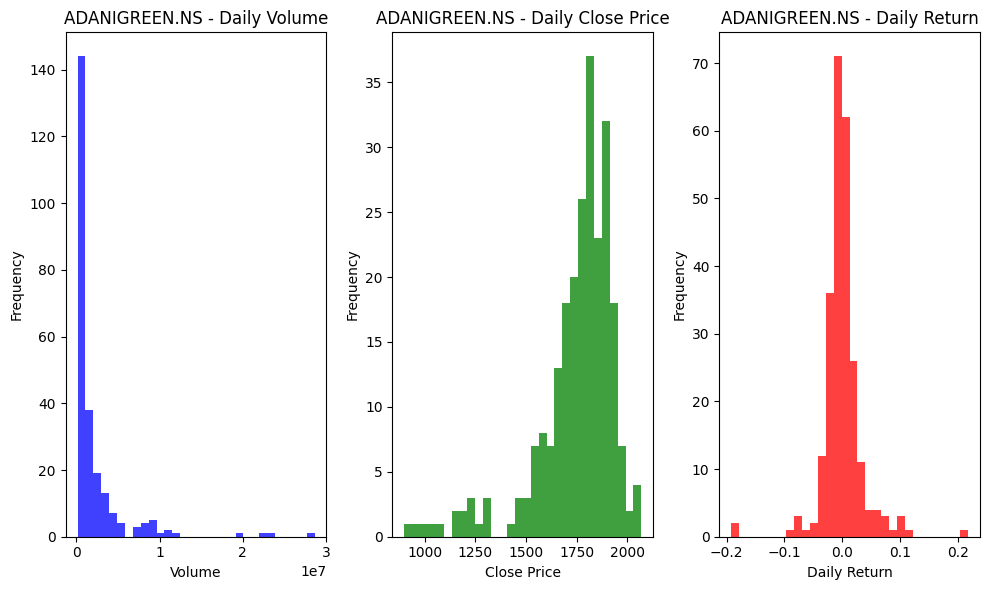

Results for ADANIPORTS.NS:
Z-Score: 0.037453180220630974
T-Score: 0.5850373773597132
95% Confidence Interval: (-0.002282644991553599, 0.004211433811205118)


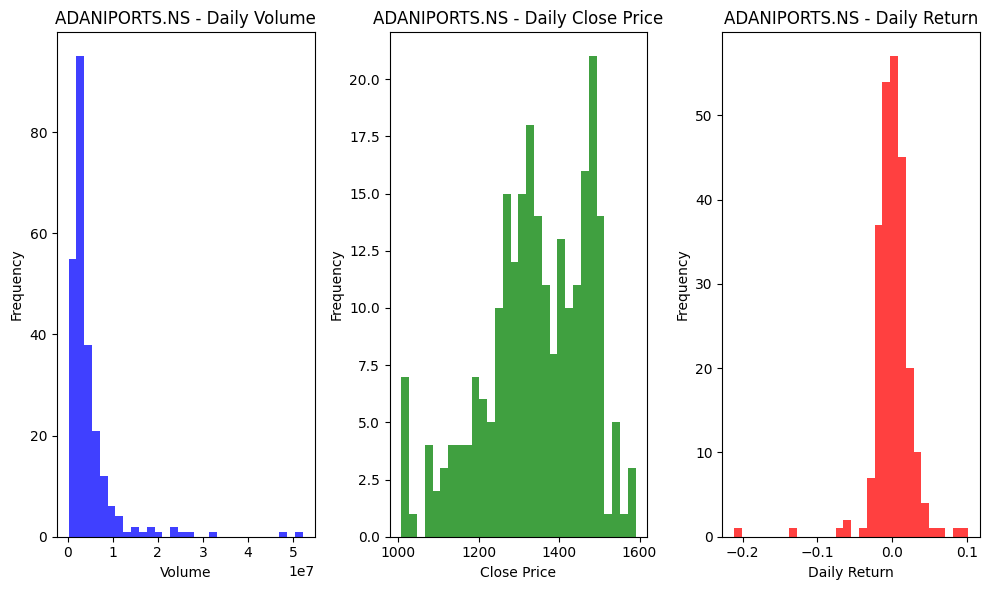

Results for APOLLOHOSP.NS:
Z-Score: 0.08591807178356163
T-Score: 1.3420831846041739
95% Confidence Interval: (-0.0005696624529317358, 0.003005683177132101)


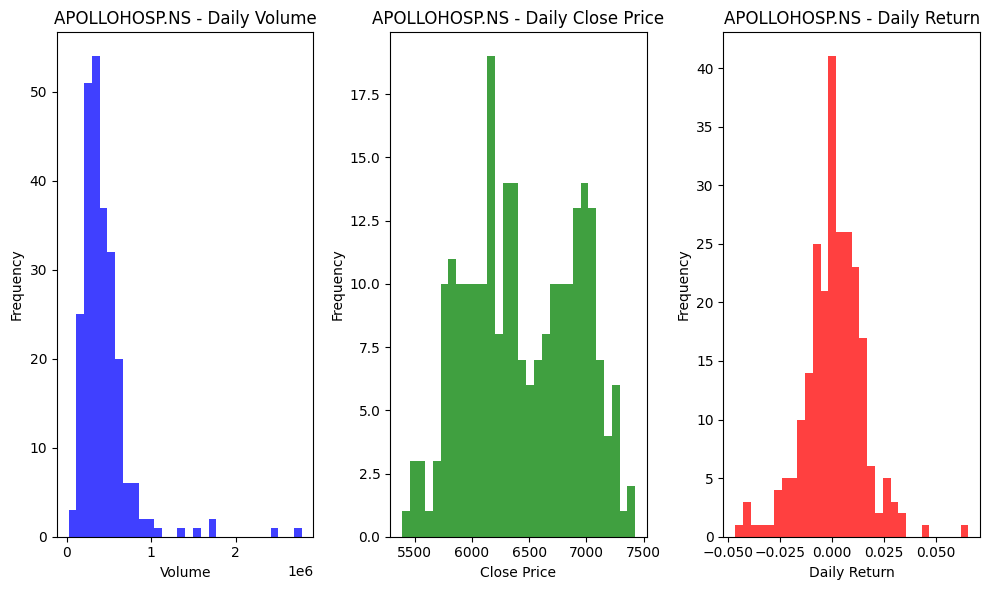

Results for ASIANPAINT.NS:
Z-Score: -0.0843193892190442
T-Score: -1.317110964641374
95% Confidence Interval: (-0.002780960111687778, 0.00055220391602945)


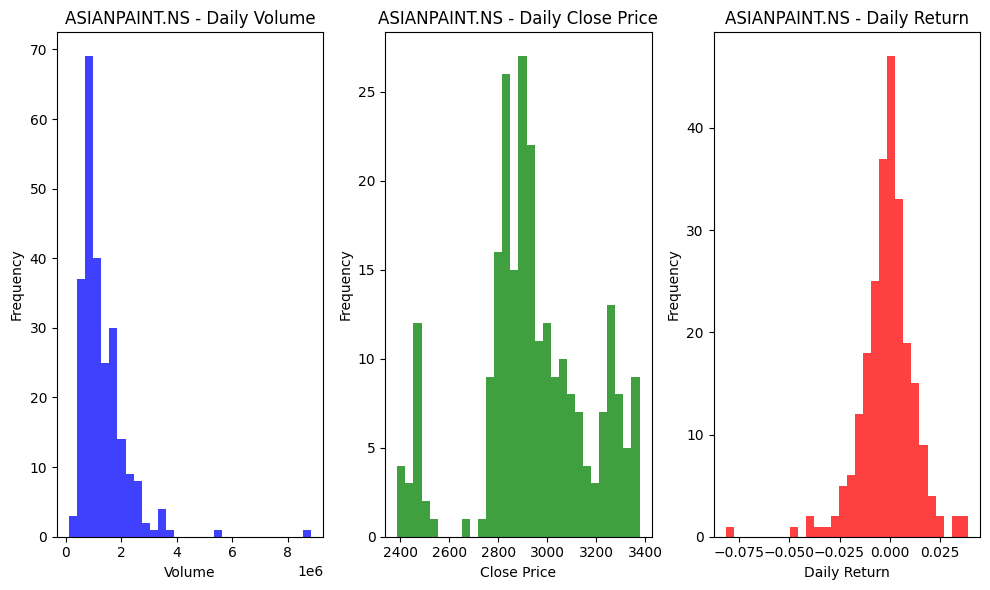

Results for AXISBANK.NS:
Z-Score: 0.013810355898721087
T-Score: 0.21572465536428387
95% Confidence Interval: (-0.0017449632795407868, 0.002174177564067345)


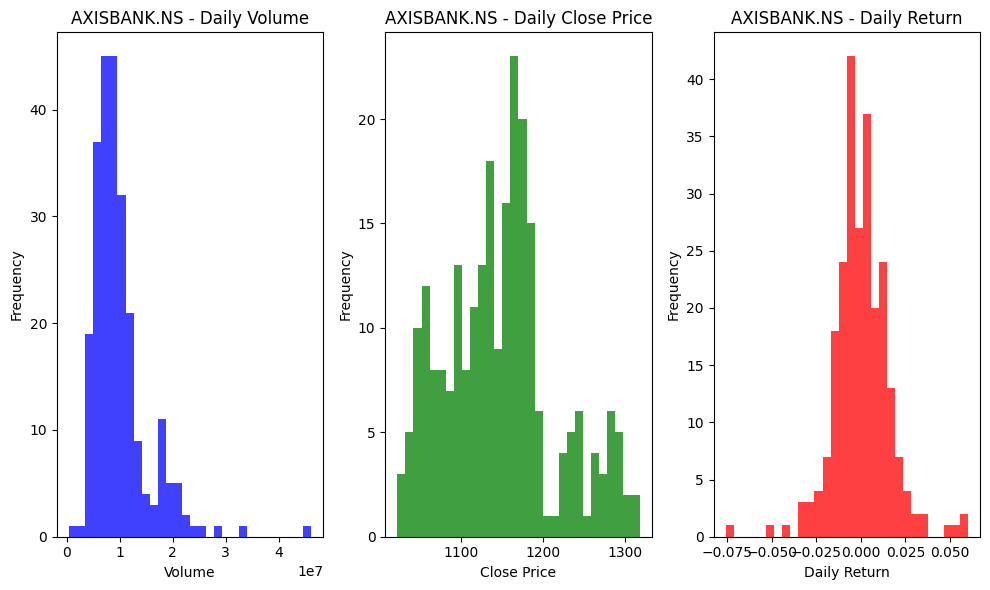

Results for BAJAJ-AUTO.NS:
Z-Score: 0.08926949542969335
T-Score: 1.394434095496226
95% Confidence Interval: (-0.0006700589525278611, 0.003918060351044802)


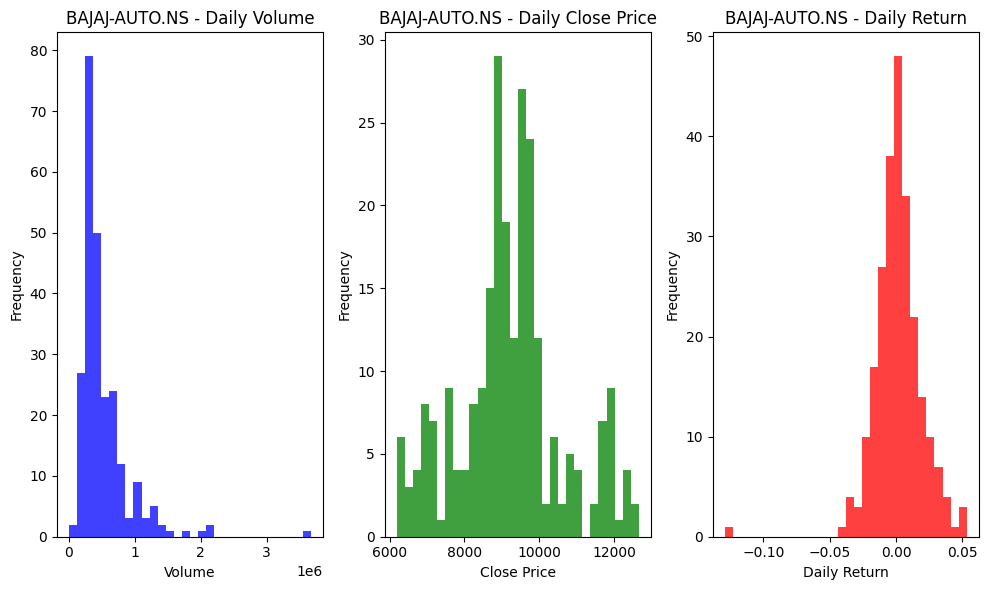

Results for BAJFINANCE.NS:
Z-Score: -0.002596440095266493
T-Score: -0.04055769082513234
95% Confidence Interval: (-0.0020953502481248355, 0.002010804447841369)


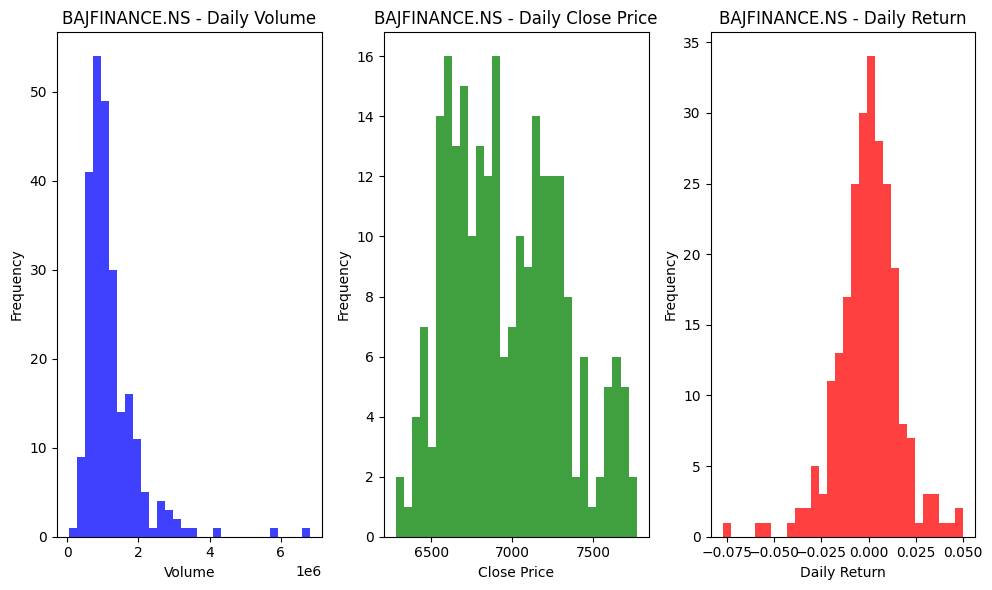

Results for BAJAJFINSV.NS:
Z-Score: -0.0016418159803618948
T-Score: -0.025645985457039708
95% Confidence Interval: (-0.001792911905587463, 0.0017468253835723835)


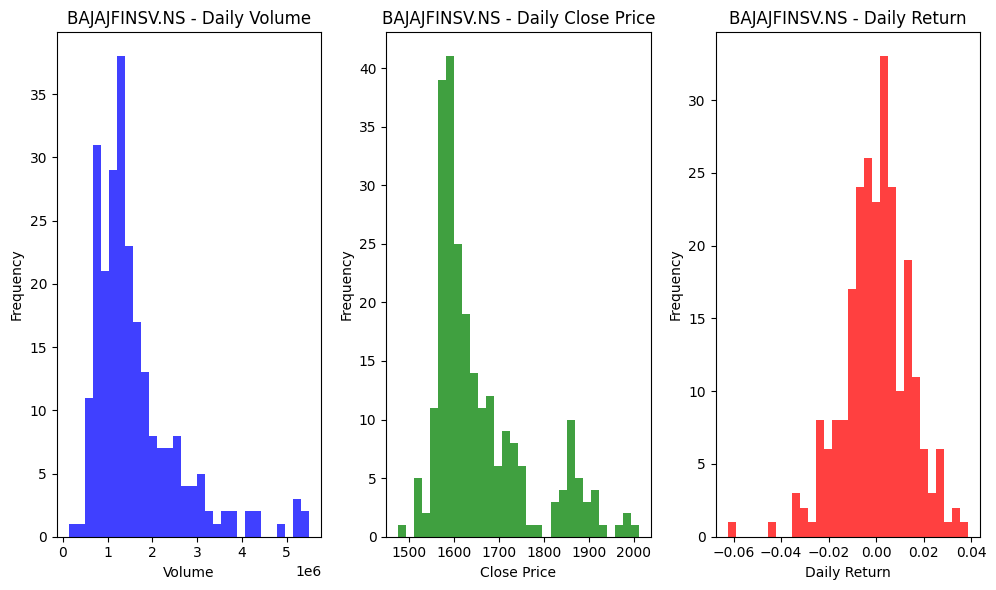

Results for BEL.NS:
Z-Score: 0.12146363612735965
T-Score: 1.897322649396309
95% Confidence Interval: (-0.00011489308088342802, 0.0061323945647008505)


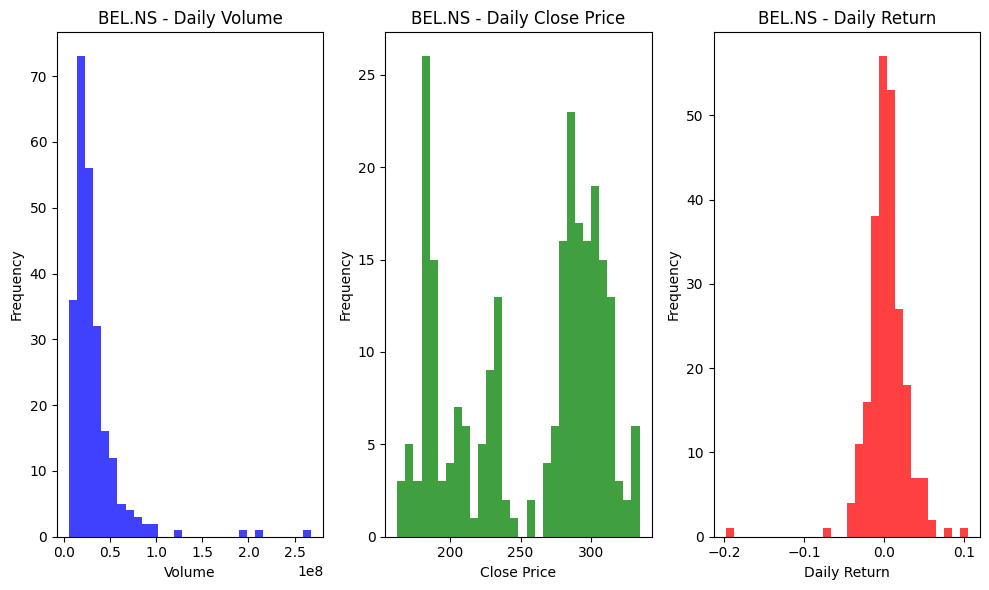

Results for BHARTIARTL.NS:
Z-Score: 0.14182859307572632
T-Score: 2.2154334462079763
95% Confidence Interval: (0.00022859820174312416, 0.0038945480879813074)


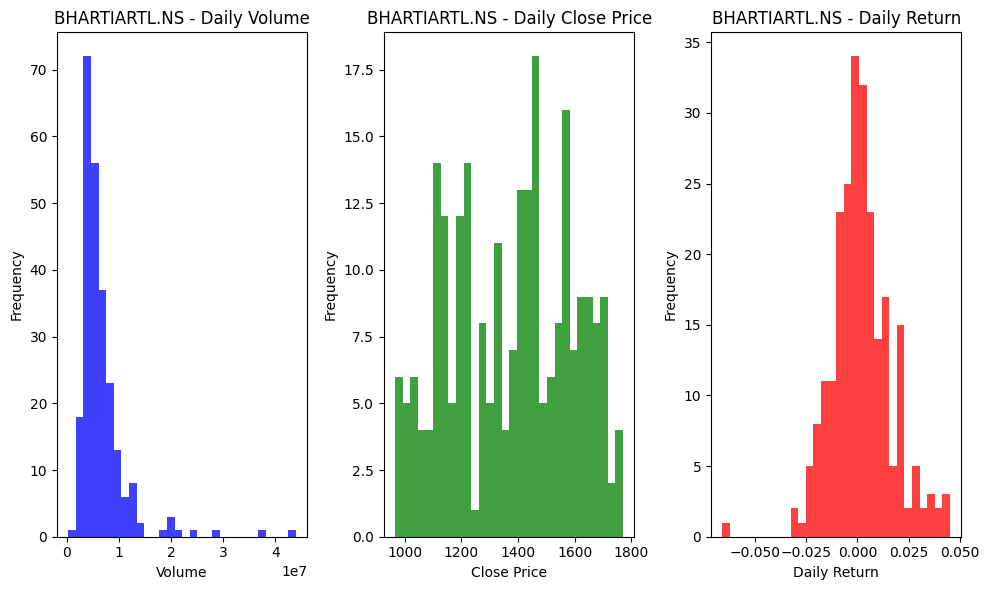

Results for BPCL.NS:
Z-Score: 0.07212616232567004
T-Score: 1.1266466718569104
95% Confidence Interval: (-0.0012236439980874744, 0.004493882656940362)


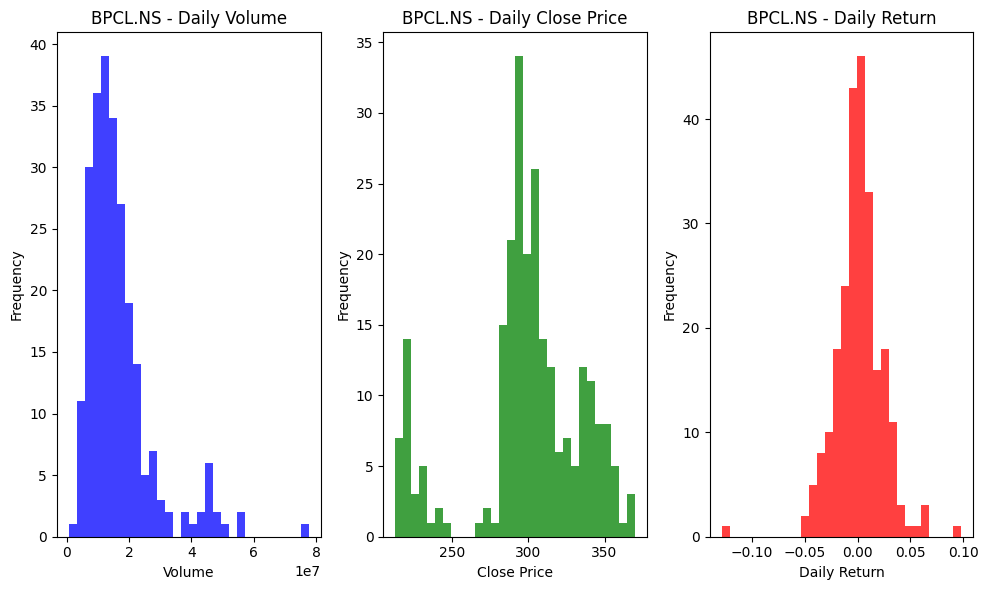

Results for CIPLA.NS:
Z-Score: 0.056303771093305234
T-Score: 0.8794930198676192
95% Confidence Interval: (-0.001128216939779645, 0.0029484056464326126)


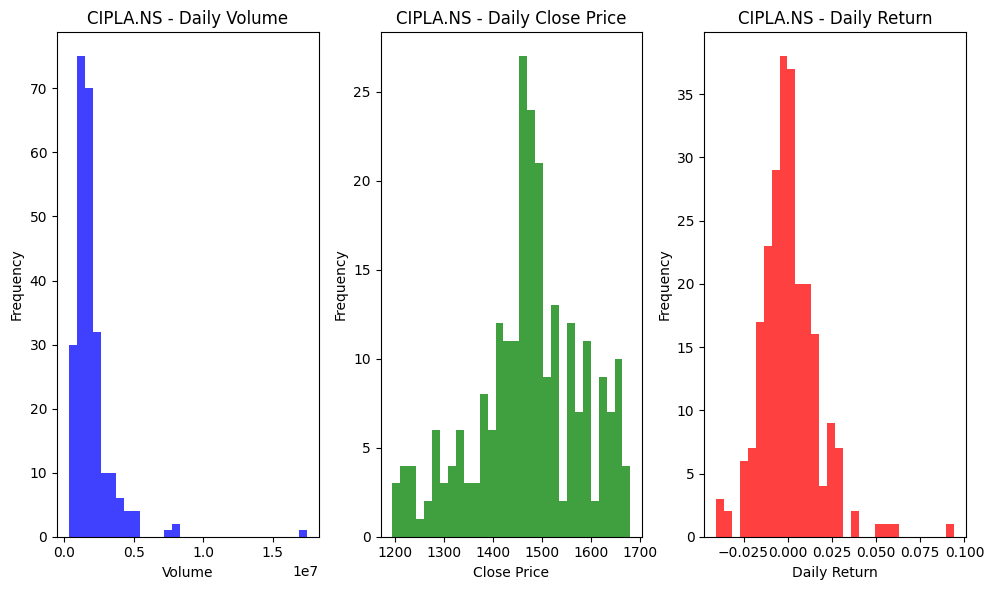

Results for COALINDIA.NS:
Z-Score: 0.0530483618146291
T-Score: 0.8286419013401718
95% Confidence Interval: (-0.0015643522178428225, 0.0038362843604773144)


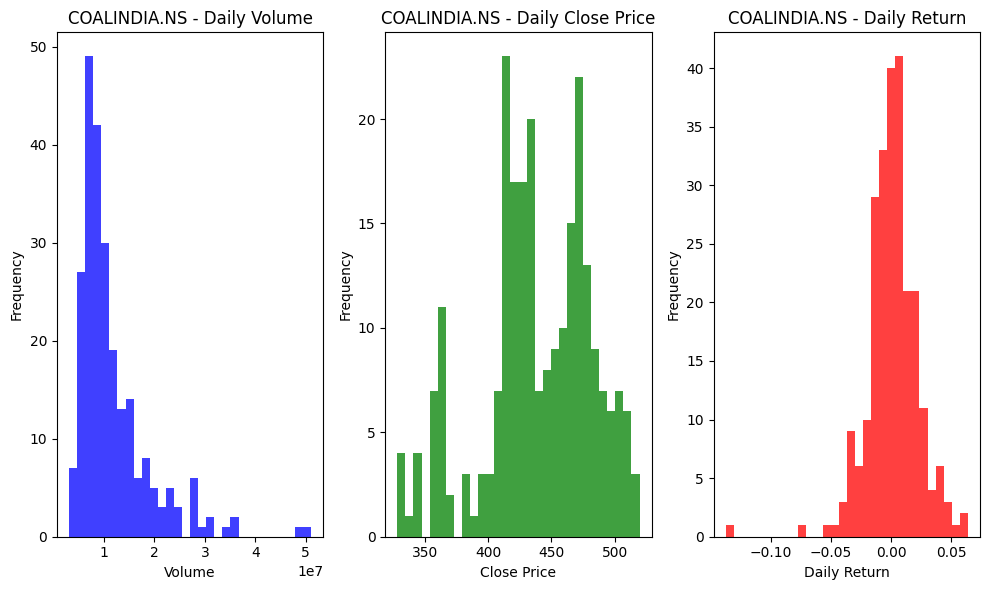

Results for DRREDDY.NS:
Z-Score: 0.044403476497775894
T-Score: 0.6936044758517658
95% Confidence Interval: (-0.0010247234228770528, 0.0021386076191992156)


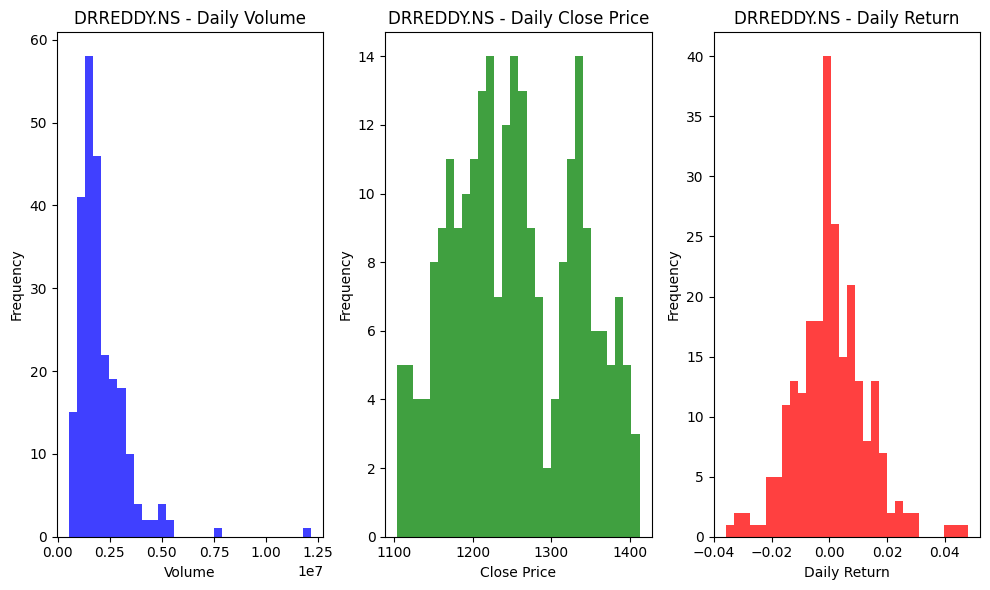

Results for EICHERMOT.NS:
Z-Score: 0.05353275379419541
T-Score: 0.8362083459430109
95% Confidence Interval: (-0.0011270122862874926, 0.0027897598257076166)


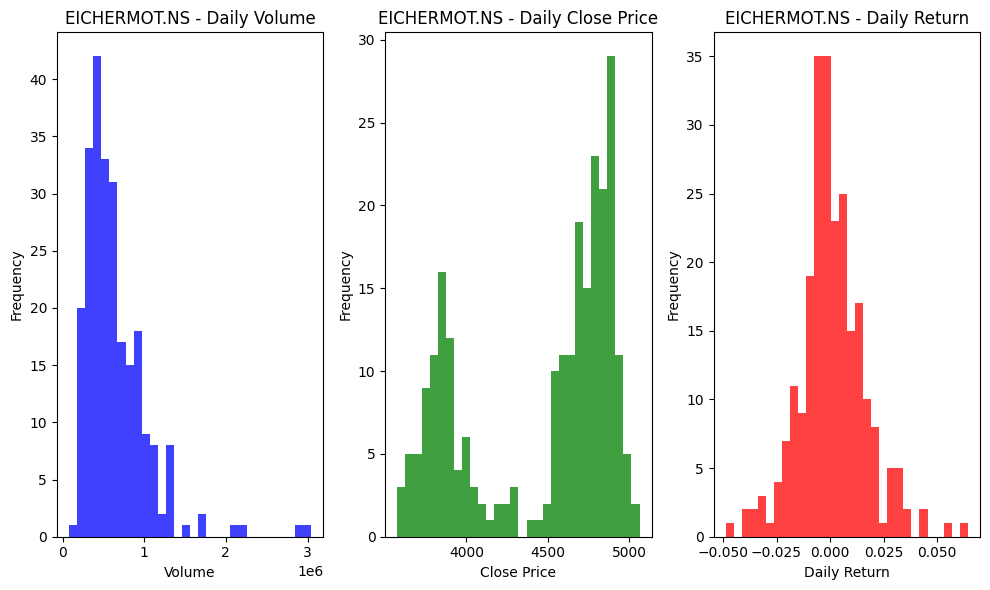

Results for GRASIM.NS:
Z-Score: 0.07305850170161063
T-Score: 1.1412102784744602
95% Confidence Interval: (-0.0008046150492587118, 0.003021063832505053)


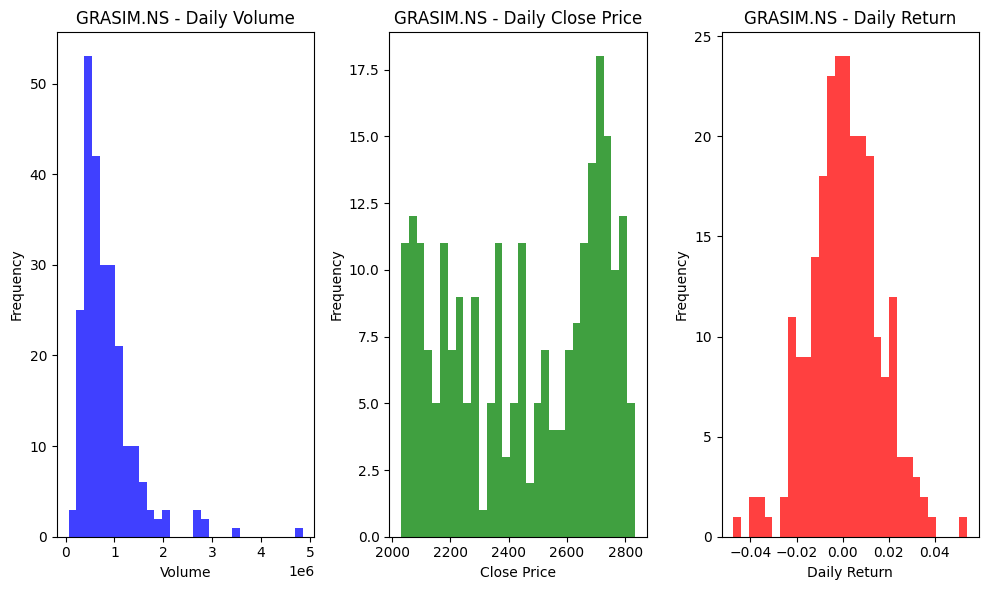

Results for HCLTECH.NS:
Z-Score: 0.1048344299959174
T-Score: 1.6375661457989452
95% Confidence Interval: (-0.0003121295016476882, 0.003389311995323547)


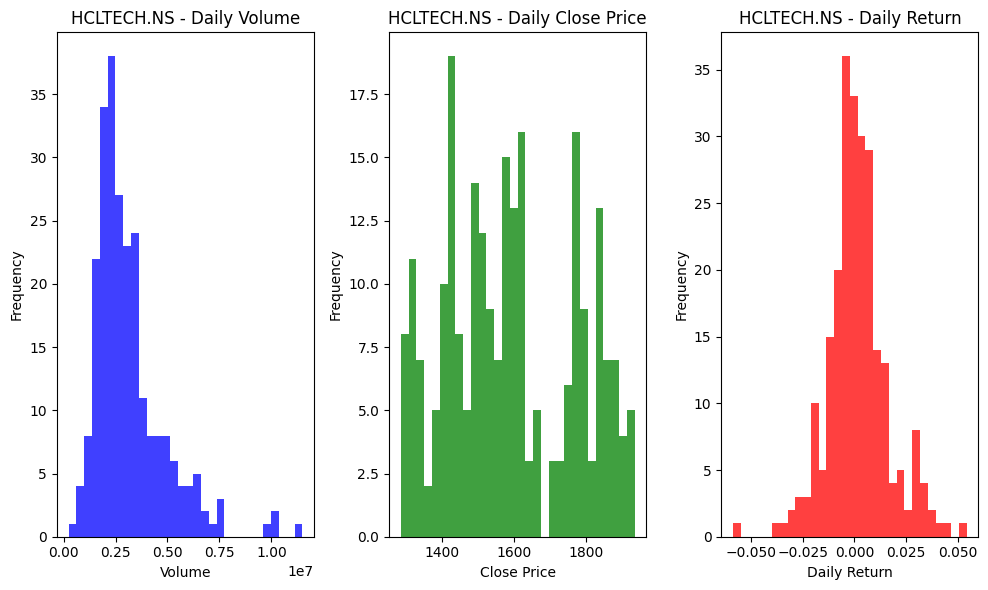

Results for HDFCBANK.NS:
Z-Score: 0.045823867007232434
T-Score: 0.7157916848840534
95% Confidence Interval: (-0.00112856226142436, 0.0024169619750894016)


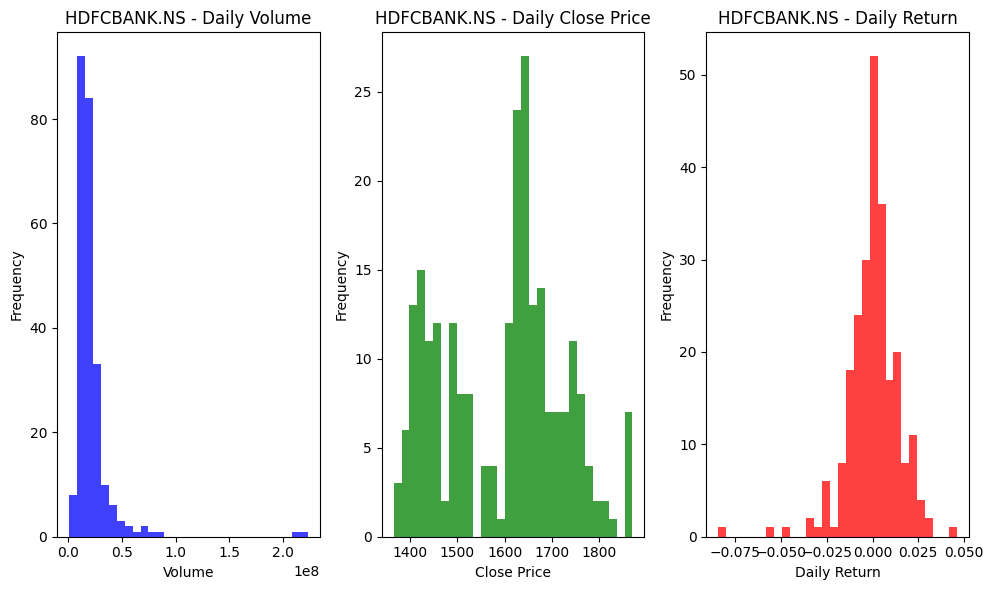

Results for HDFCLIFE.NS:
Z-Score: -0.015583998745852281
T-Score: -0.24342984230824494
95% Confidence Interval: (-0.002139487521038103, 0.0016688440069989531)


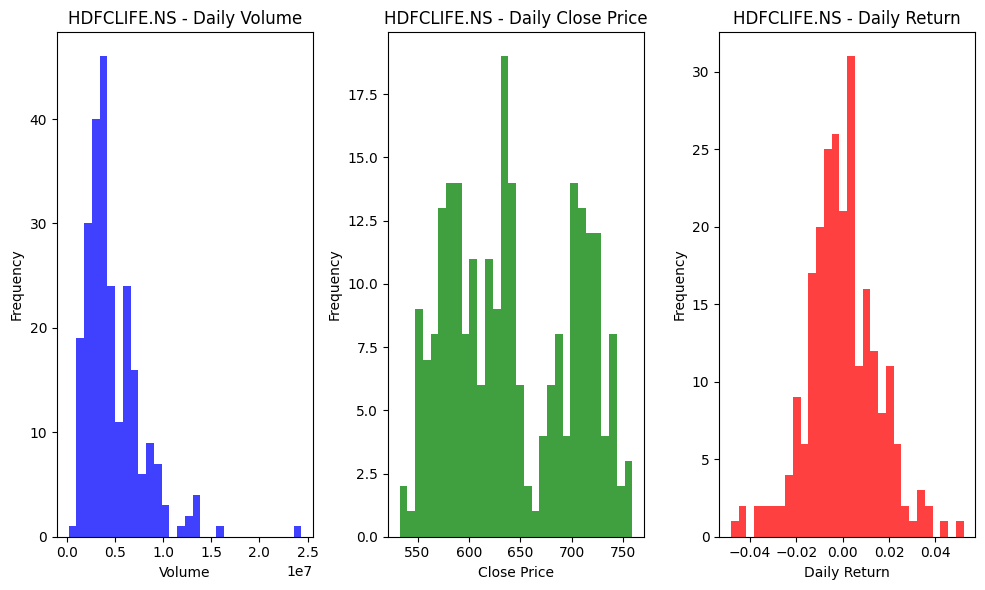

Results for HEROMOTOCO.NS:
Z-Score: 0.05437454701473708
T-Score: 0.8493575763988429
95% Confidence Interval: (-0.0011642788741384308, 0.0029294952935944277)


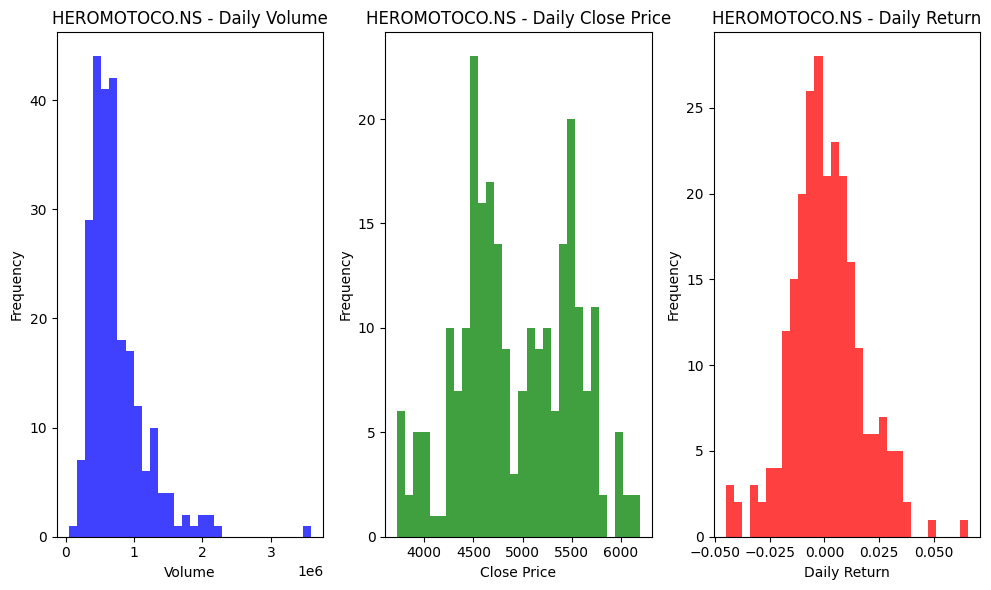

Results for HINDALCO.NS:
Z-Score: 0.053021318303720366
T-Score: 0.8282194681955511
95% Confidence Interval: (-0.001503137951914215, 0.003684247393891605)


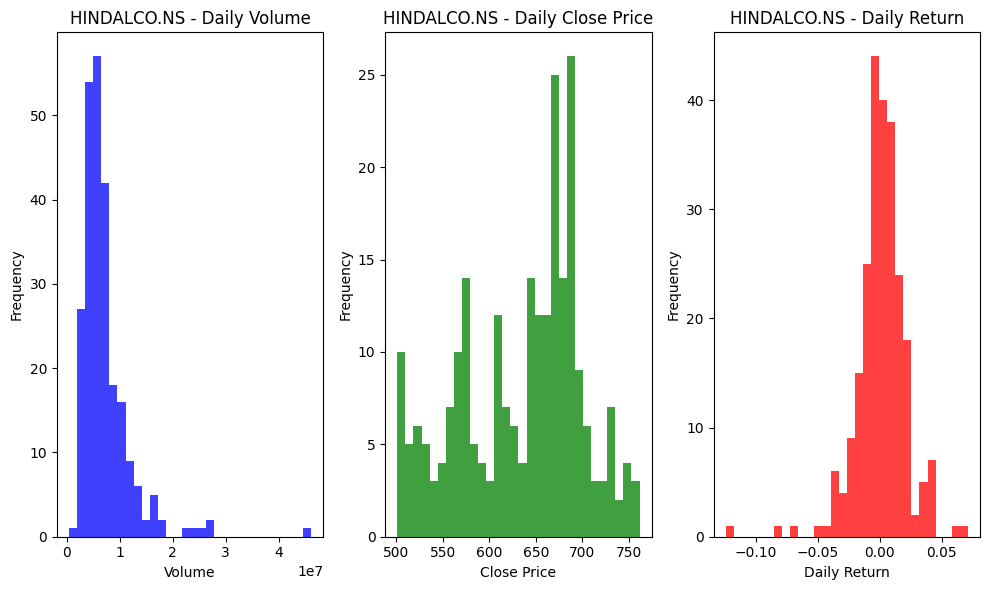

Results for HINDUNILVR.NS:
Z-Score: -0.010896163126164727
T-Score: -0.17020350904950818
95% Confidence Interval: (-0.0018207154608246223, 0.0015310936289683605)


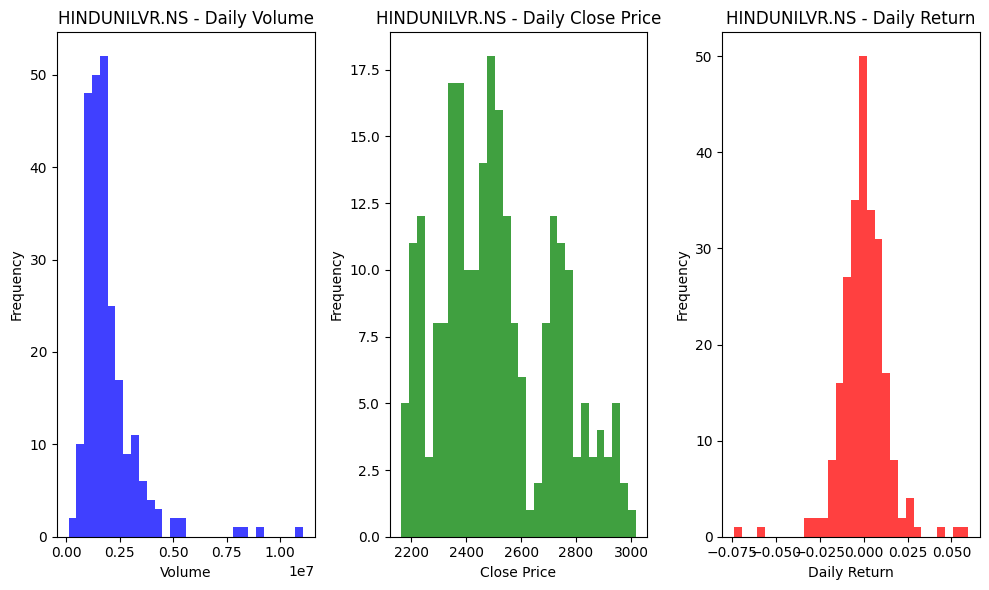

Results for ICICIBANK.NS:
Z-Score: 0.08825658467221426
T-Score: 1.378611923665579
95% Confidence Interval: (-0.000493815909243018, 0.0027970084598493822)


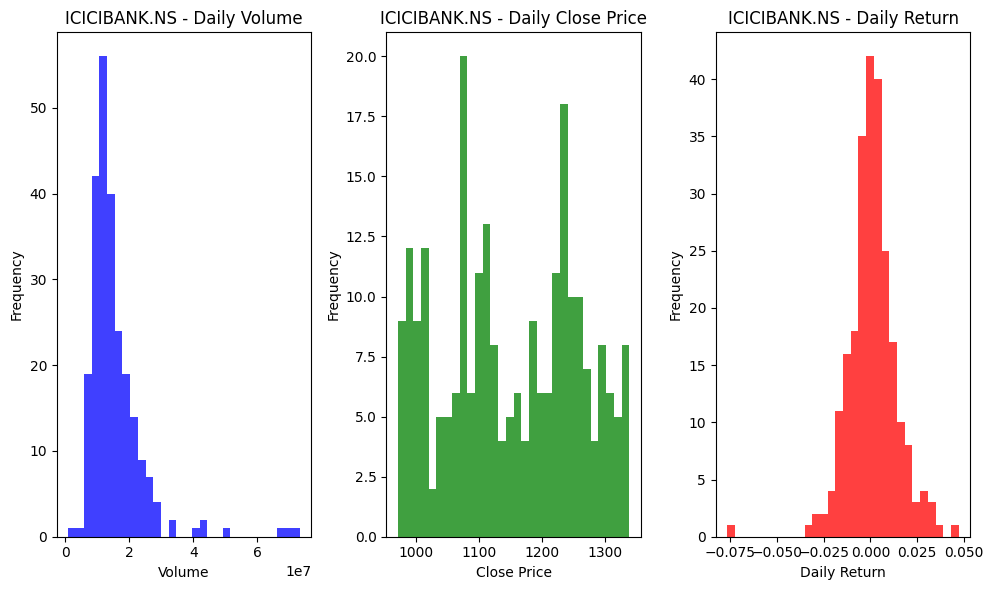

Results for INDUSINDBK.NS:
Z-Score: -0.07824005500841075
T-Score: -1.2221487285447177
95% Confidence Interval: (-0.004060060584493519, 0.000950964476326106)


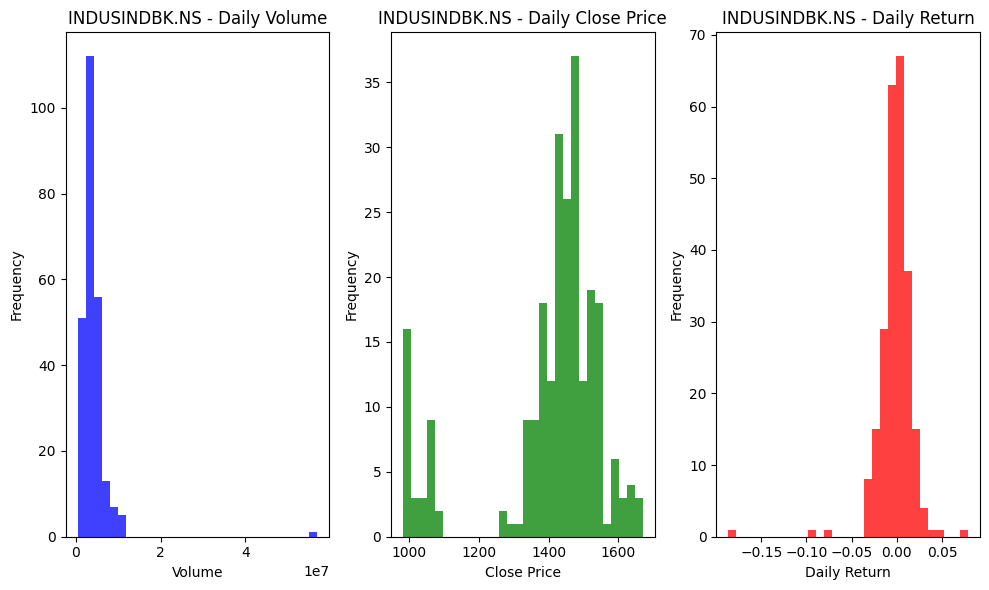

Results for INFY.NS:
Z-Score: 0.08936806762797665
T-Score: 1.395973842455617
95% Confidence Interval: (-0.0005457342732668609, 0.0032011195511947674)


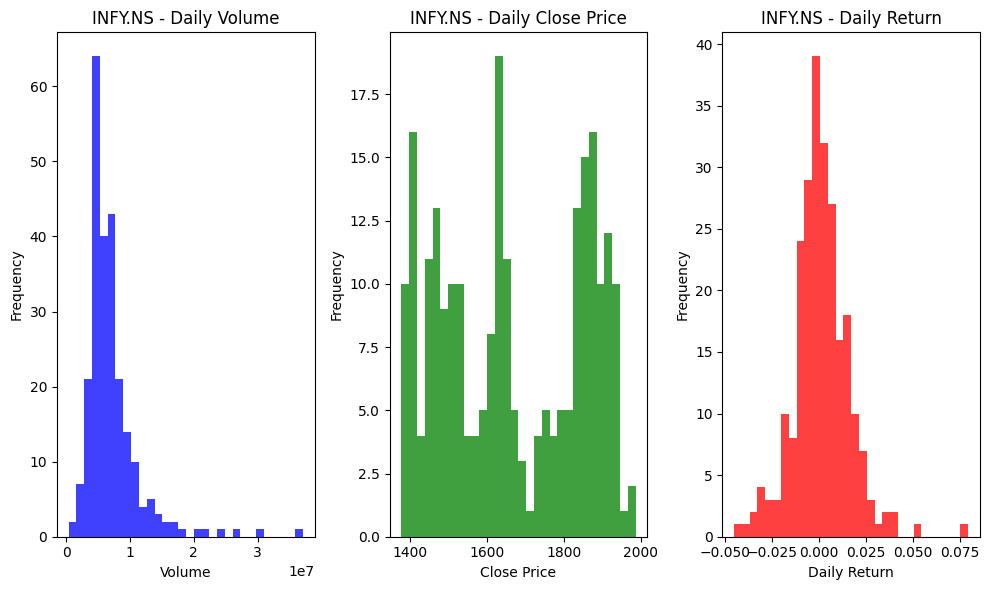

Results for IOC.NS:
Z-Score: 0.04759978724767161
T-Score: 0.7435324458487057
95% Confidence Interval: (-0.0018362411867294253, 0.004063052789786777)


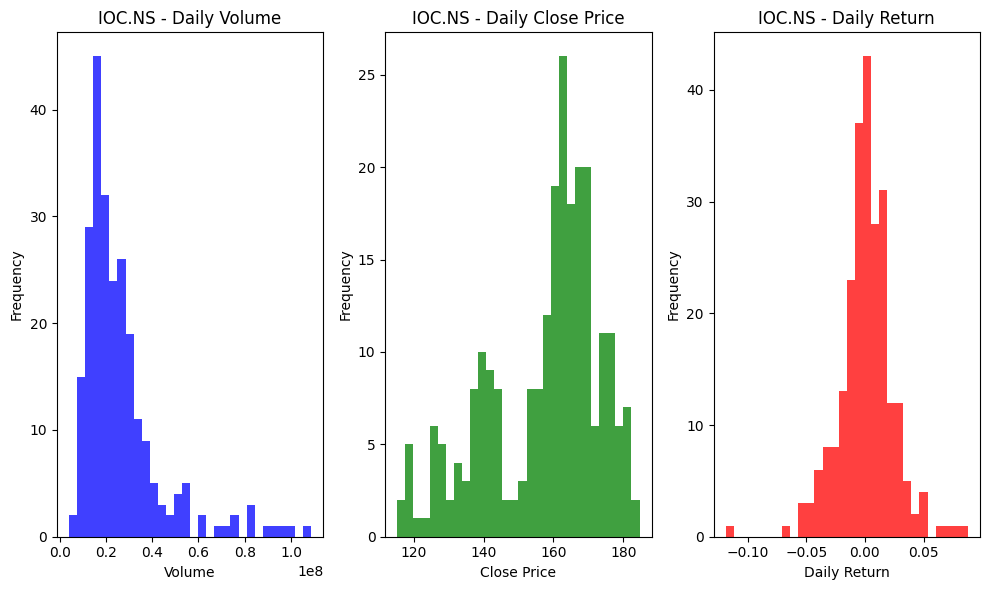

Results for ITC.NS:
Z-Score: 0.017347401718385166
T-Score: 0.27097507729768056
95% Confidence Interval: (-0.0012939572637415855, 0.0017067548977182804)


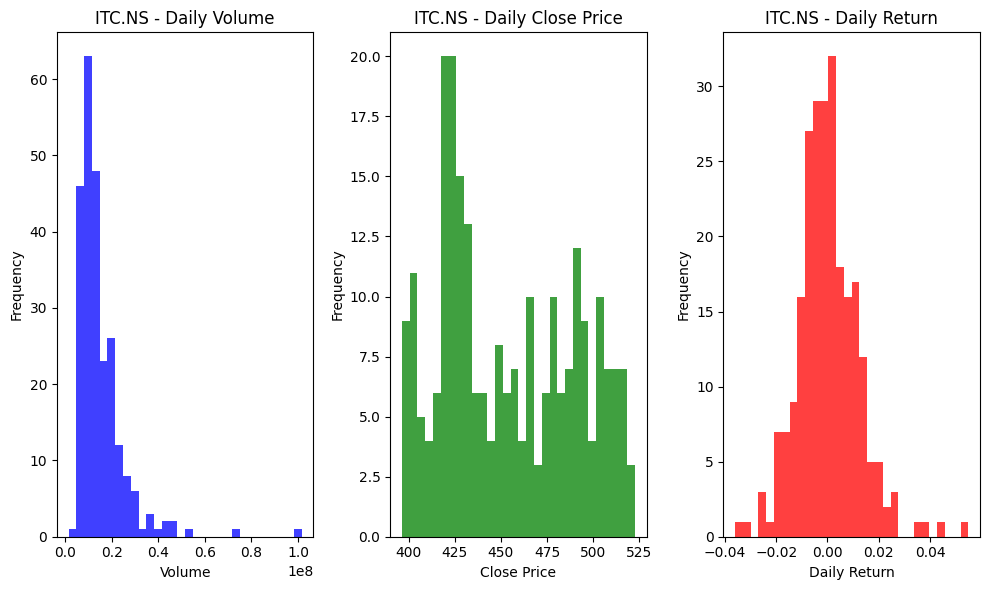

Results for JSWSTEEL.NS:
Z-Score: 0.051771489184011074
T-Score: 0.8086965132412547
95% Confidence Interval: (-0.0012606348901044034, 0.003016711817828699)


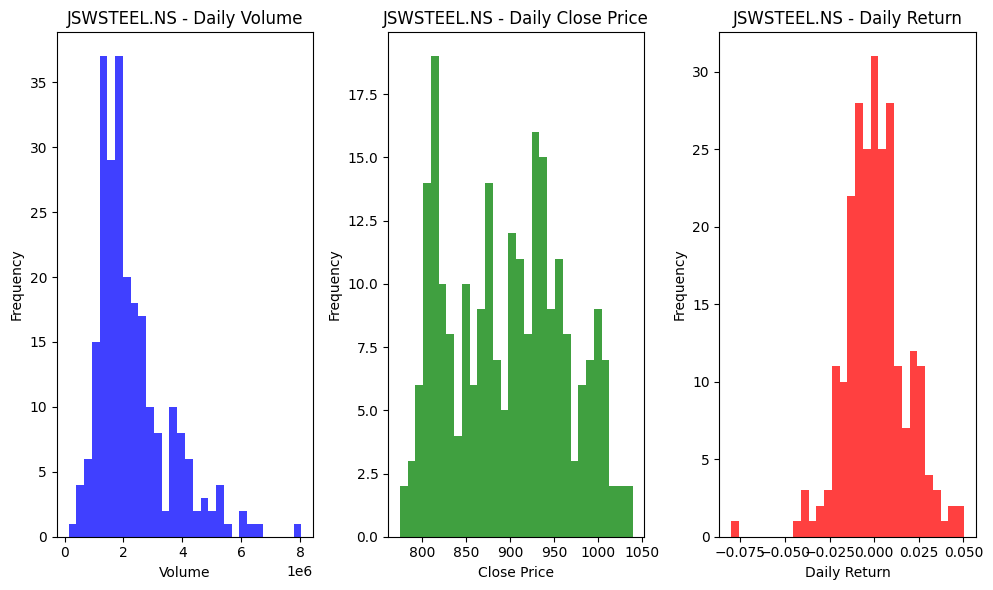

Results for KOTAKBANK.NS:
Z-Score: -0.005414206303196009
T-Score: -0.08457260604965677
95% Confidence Interval: (-0.0019276427505903046, 0.001768929767016393)


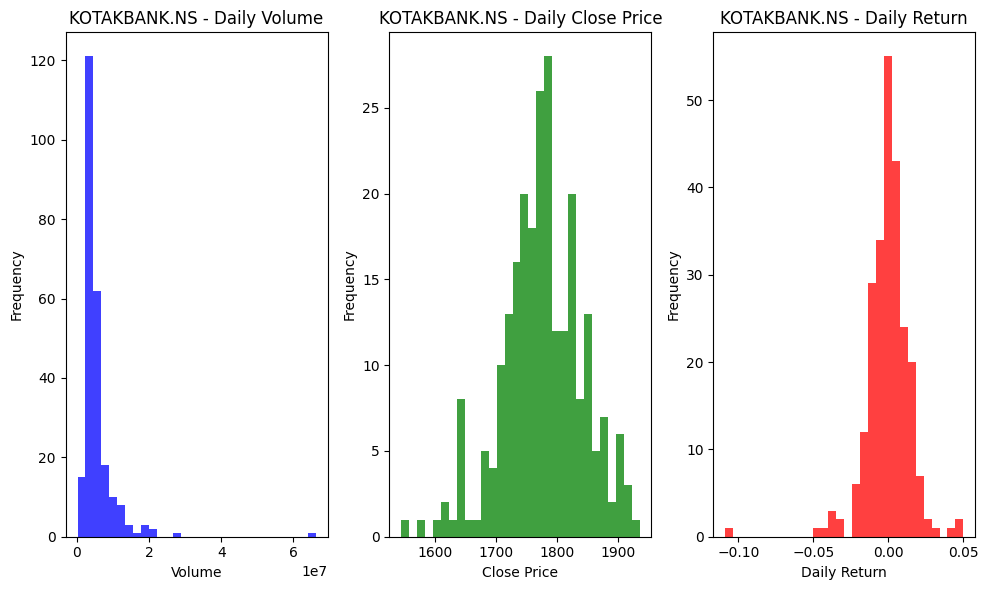

Results for LT.NS:
Z-Score: 0.03774355667608384
T-Score: 0.5895732025938963
95% Confidence Interval: (-0.0015777308175060334, 0.0029256325810155994)


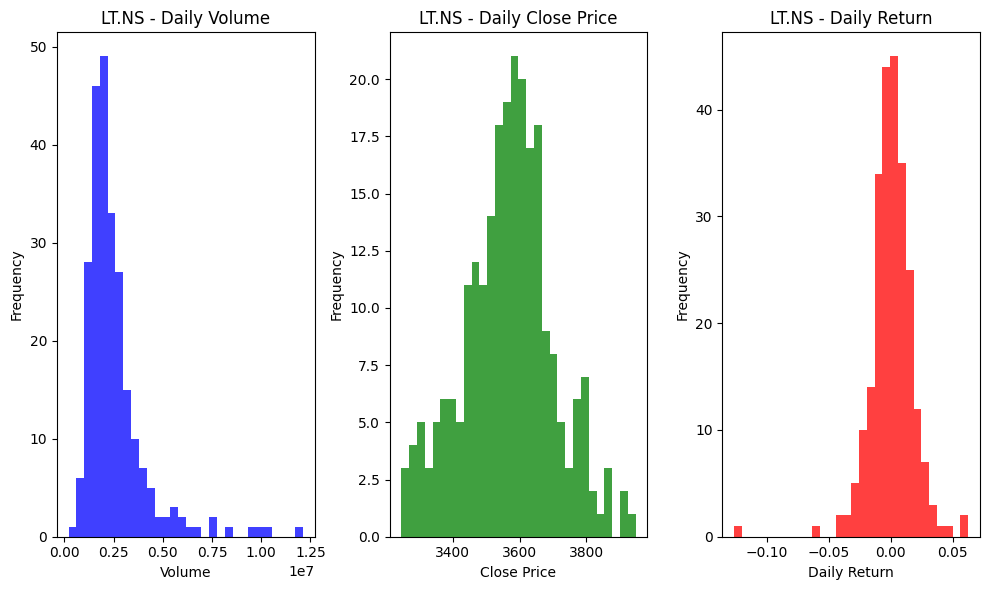

Results for M&M.NS:
Z-Score: 0.13226434067508394
T-Score: 2.066035047783163
95% Confidence Interval: (0.00012304245826359793, 0.005158659356813625)


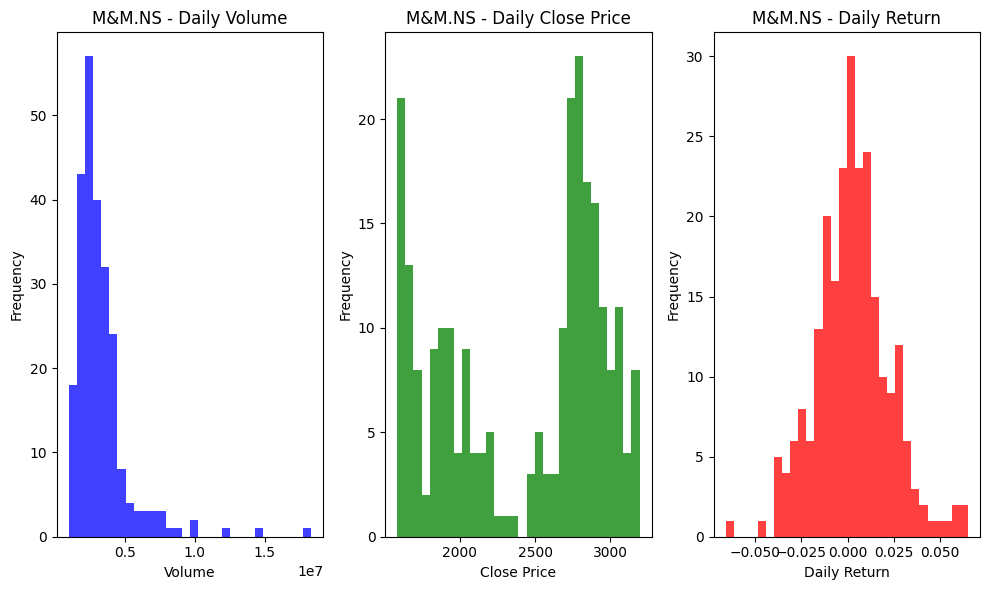

Results for MARUTI.NS:
Z-Score: 0.03142140889856457
T-Score: 0.49081809733308873
95% Confidence Interval: (-0.0013585960726186302, 0.0022603448805675803)


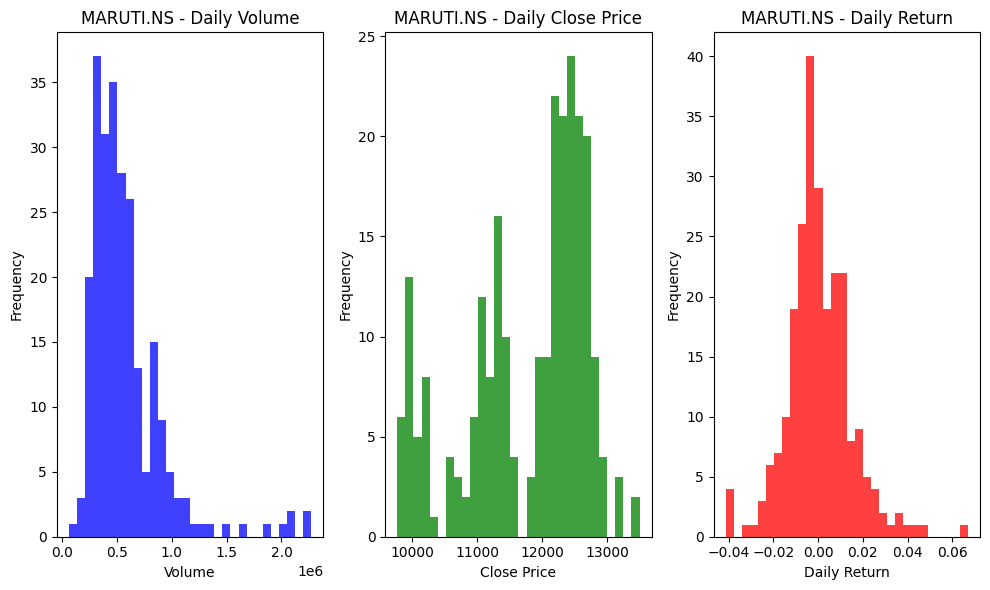

Results for NESTLEIND.NS:
Z-Score: -0.027025205609748894
T-Score: -0.422147206709704
95% Confidence Interval: (-0.001915056323929141, 0.0012390846055277986)


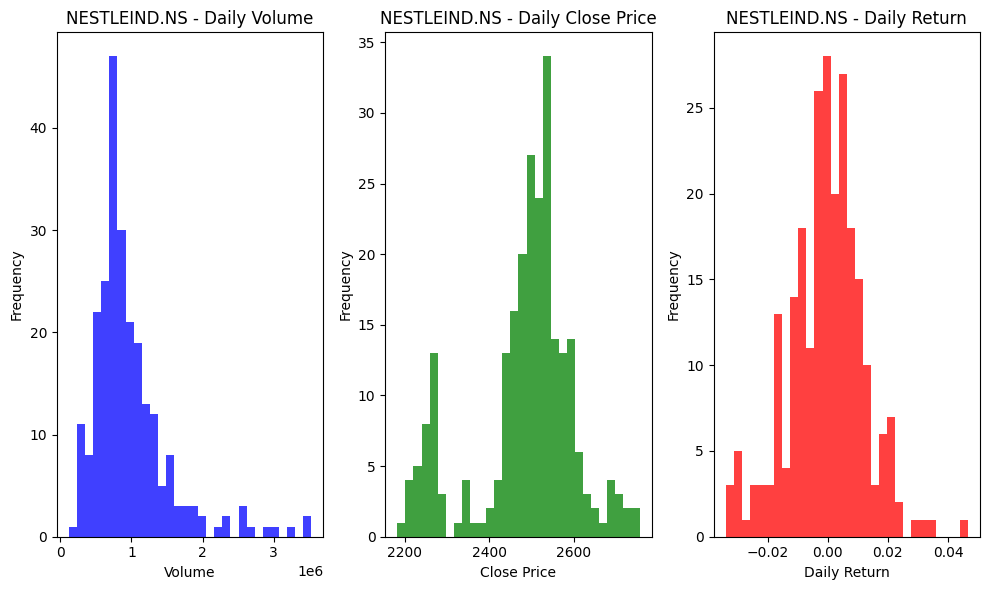

Results for NTPC.NS:
Z-Score: 0.0525240485696125
T-Score: 0.8204518666362427
95% Confidence Interval: (-0.0014973098778464059, 0.0036350399813460444)


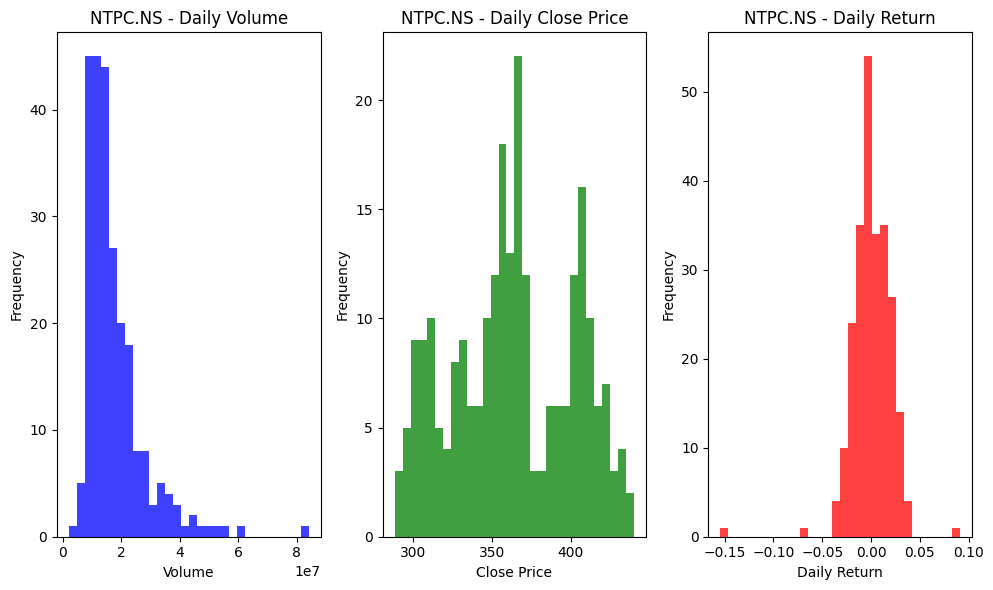

Results for ONGC.NS:
Z-Score: 0.06539640066217131
T-Score: 1.0215244341543703
95% Confidence Interval: (-0.001425074173010394, 0.004495463095063049)


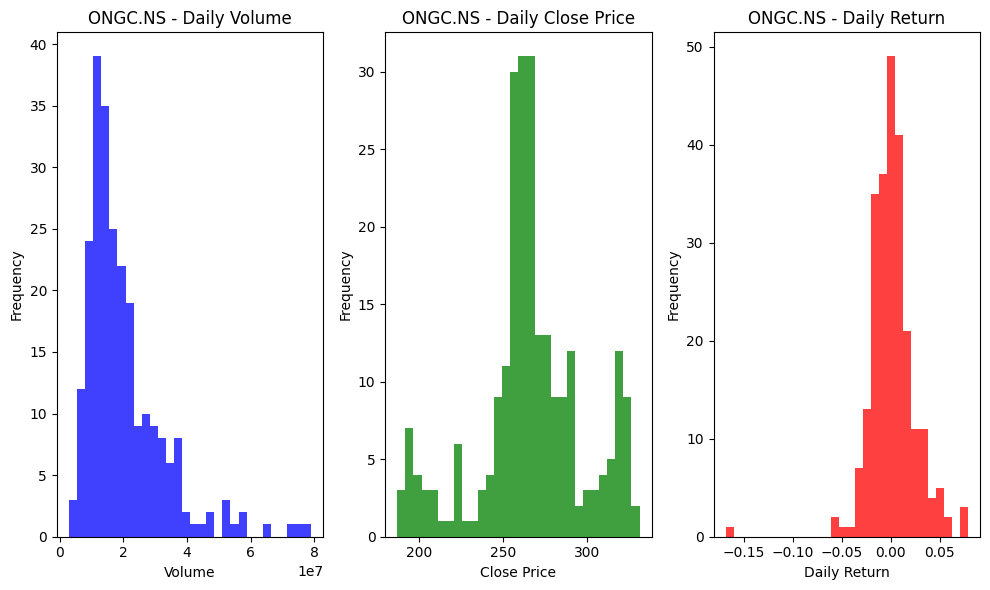

Results for POWERGRID.NS:
Z-Score: 0.09063079469411096
T-Score: 1.4156982697736853
95% Confidence Interval: (-0.0007006986484159275, 0.004281354151403168)


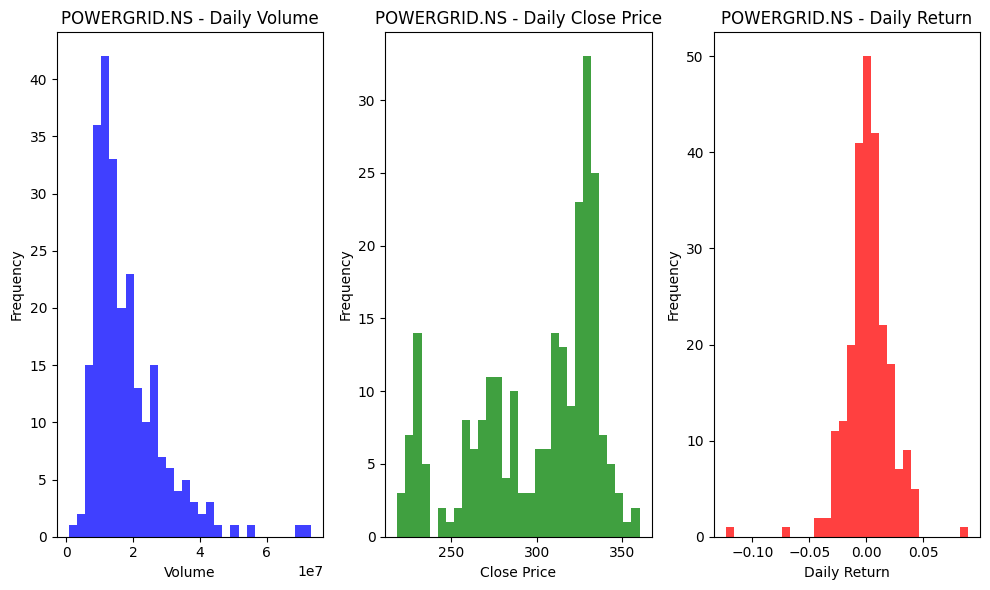

Results for RELIANCE.NS:
Z-Score: 0.015169290453466424
T-Score: 0.2369518916958401
95% Confidence Interval: (-0.0015982489739140532, 0.0020353486964242015)


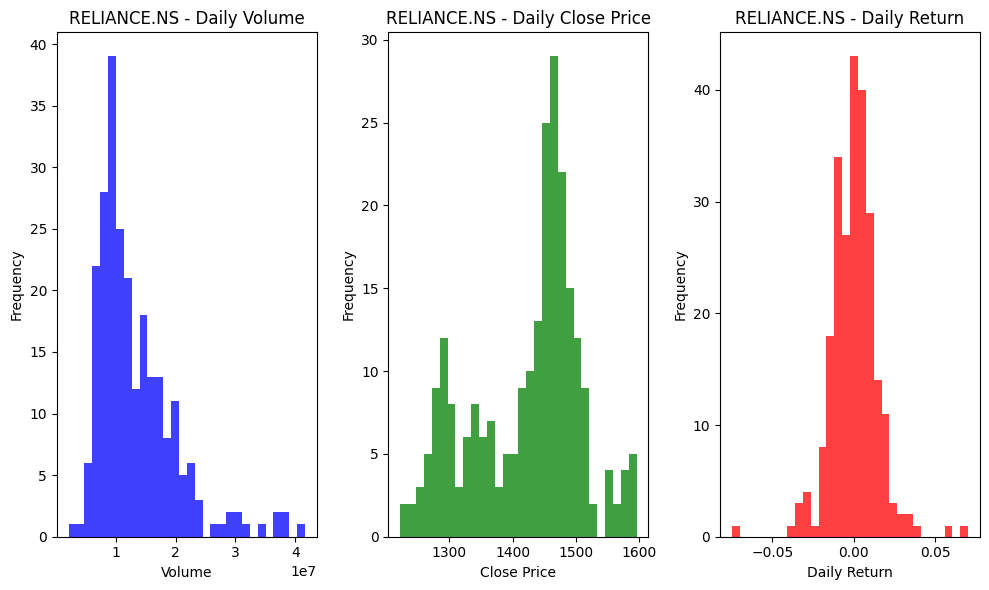

Results for SBIN.NS:
Z-Score: 0.0821686800291957
T-Score: 1.2835158131354063
95% Confidence Interval: (-0.000819260998217567, 0.0038838039370838965)


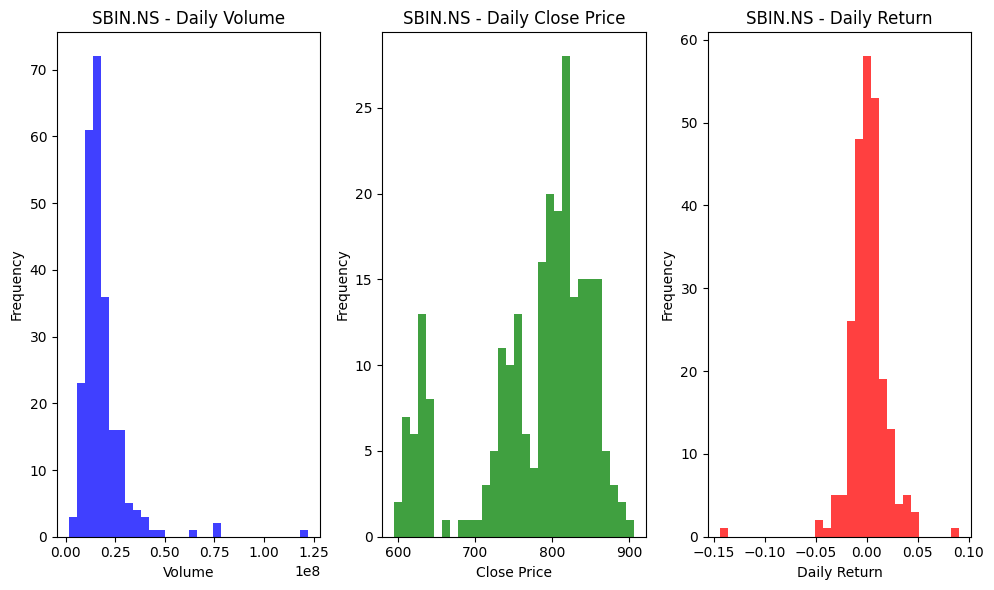

Results for SBILIFE.NS:
Z-Score: 0.0014262226618771902
T-Score: 0.022278310165394097
95% Confidence Interval: (-0.001938731196678492, 0.001983087285765215)


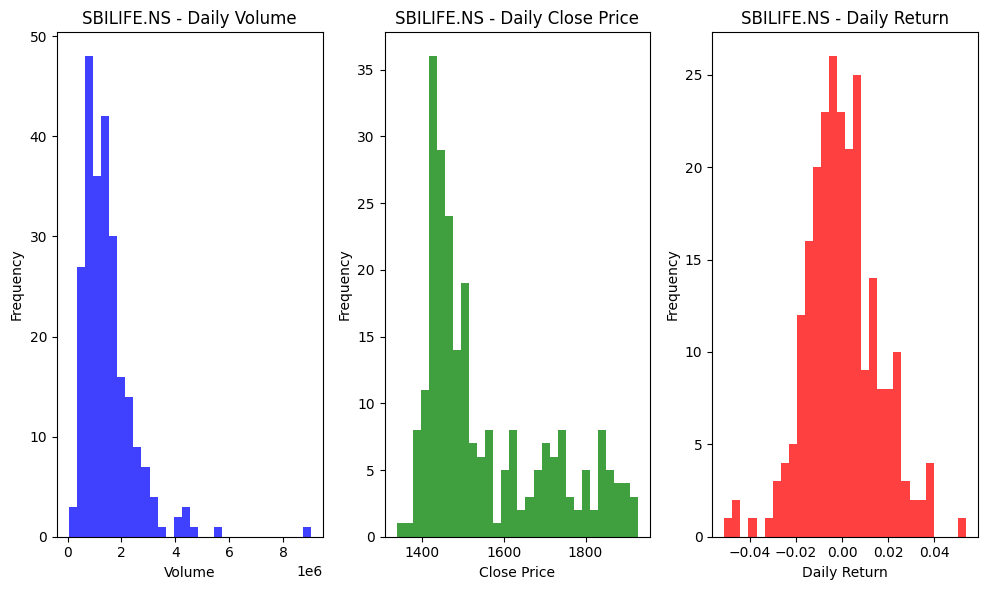

Results for SHRIRAMFIN.NS:
Z-Score: 0.09505246667725628
T-Score: 1.4847669941203379
95% Confidence Interval: (-0.0006705975537941735, 0.004776436398856146)


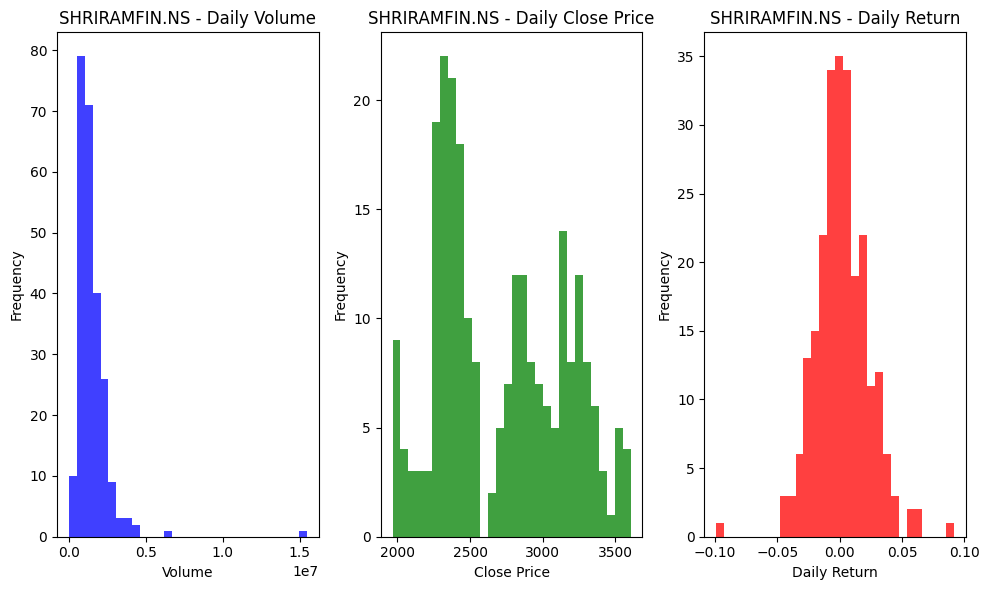

Results for SUNPHARMA.NS:
Z-Score: 0.13885035713756544
T-Score: 2.168911913666387
95% Confidence Interval: (0.0001541379983814057, 0.0032034587417201408)


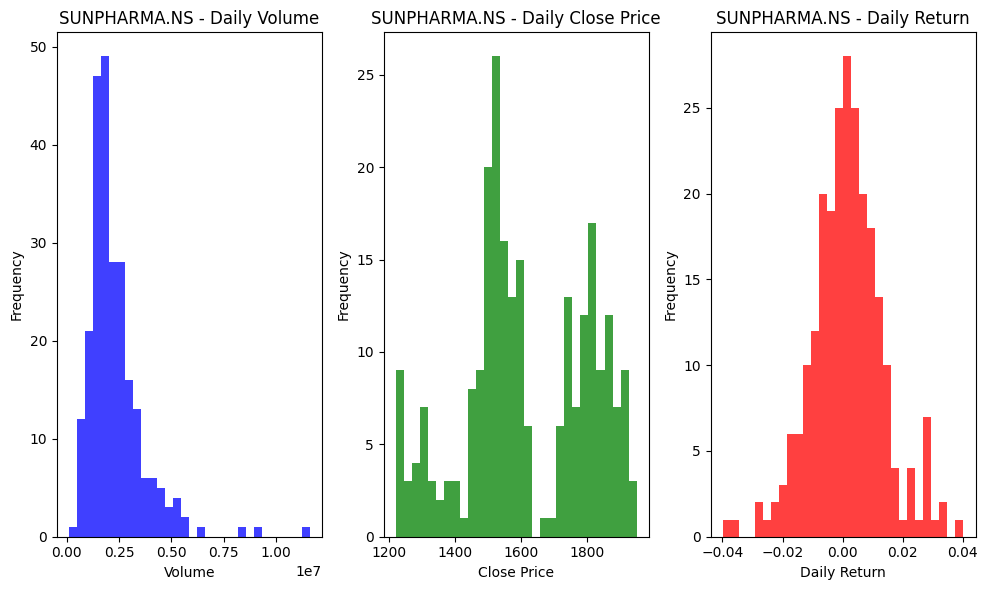

Results for TATACONSUM.NS:
Z-Score: 0.0016304311514231036
T-Score: 0.025468148743980814
95% Confidence Interval: (-0.0019752194929763774, 0.0020269656455539175)


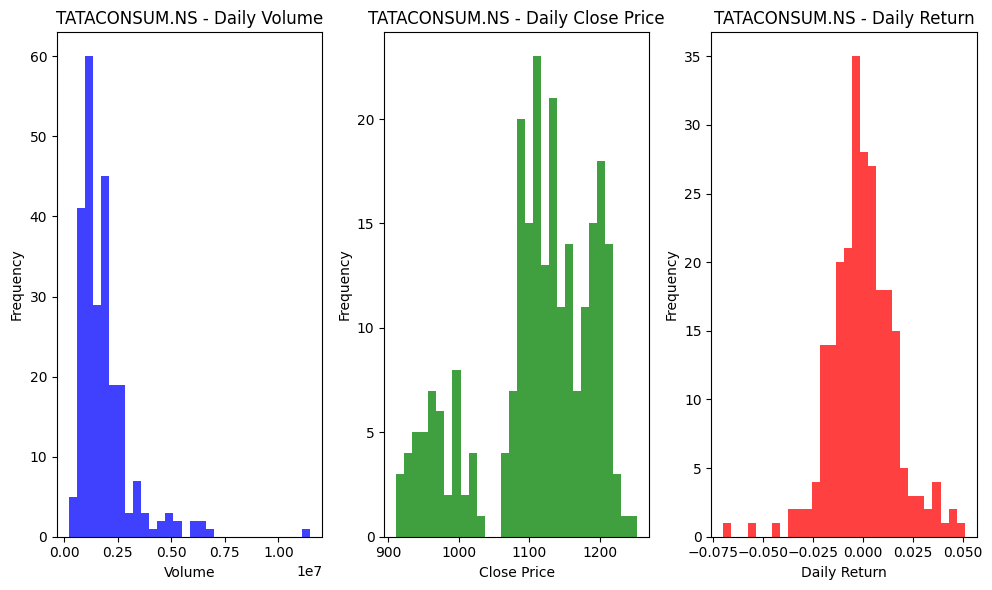

Results for TATAMOTORS.NS:
Z-Score: 0.02957064396436758
T-Score: 0.46190822487810584
95% Confidence Interval: (-0.001785140890369887, 0.0028788337869066235)


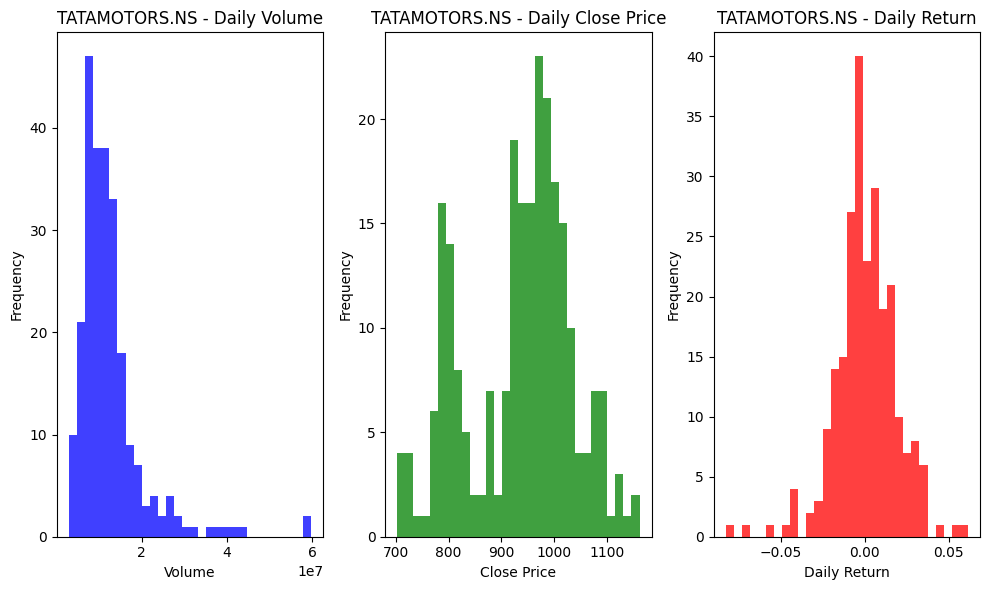

Results for TATASTEEL.NS:
Z-Score: 0.0424705866954908
T-Score: 0.6634117719480449
95% Confidence Interval: (-0.0015909747869528711, 0.0032068682357828185)


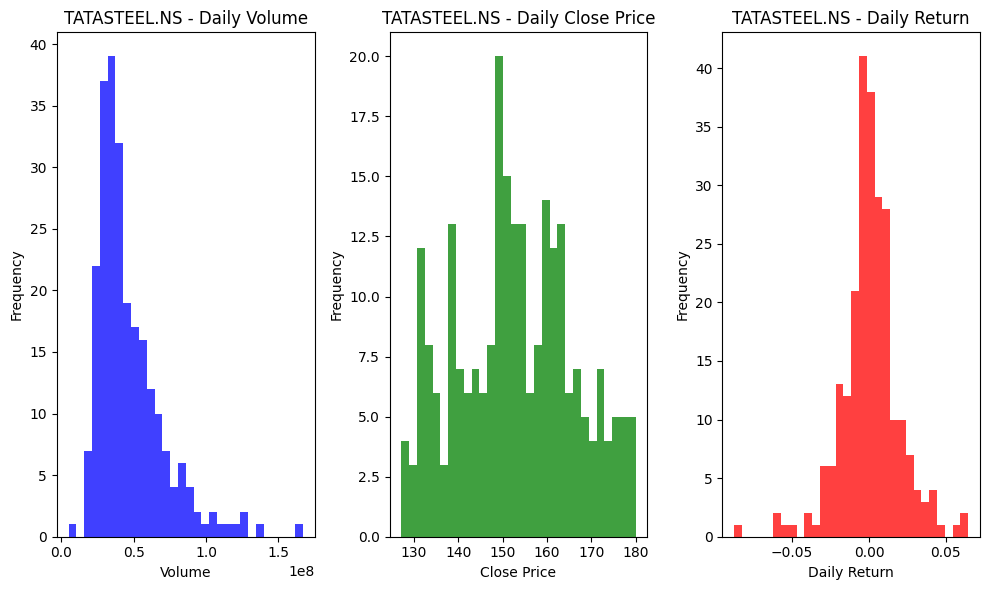

Results for TCS.NS:
Z-Score: 0.06989463395159742
T-Score: 1.091789084336156
95% Confidence Interval: (-0.0007616700928759485, 0.0026559685116846537)


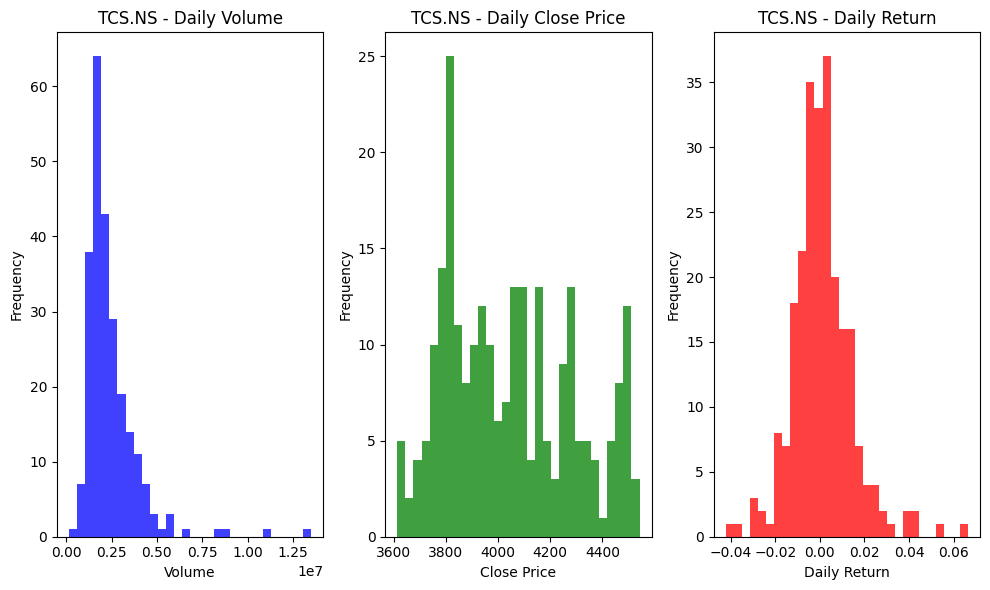

Results for TECHM.NS:
Z-Score: 0.10227132470808362
T-Score: 1.5975291613117086
95% Confidence Interval: (-0.0003885817955144859, 0.0037238602248891367)


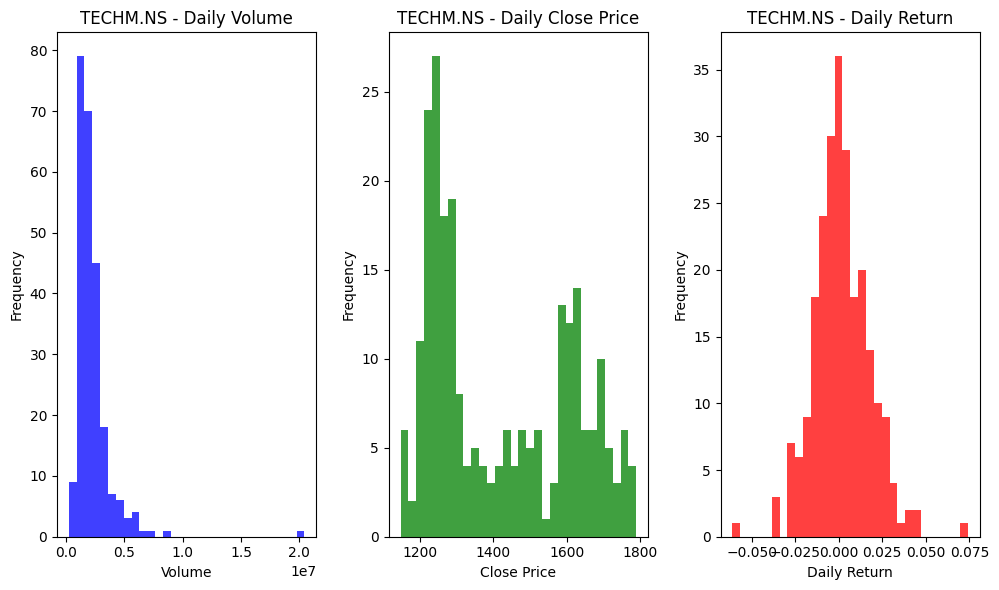

Results for TITAN.NS:
Z-Score: -0.0033199054087970793
T-Score: -0.051858580286196276
95% Confidence Interval: (-0.0018998254533712517, 0.00180235746389239)


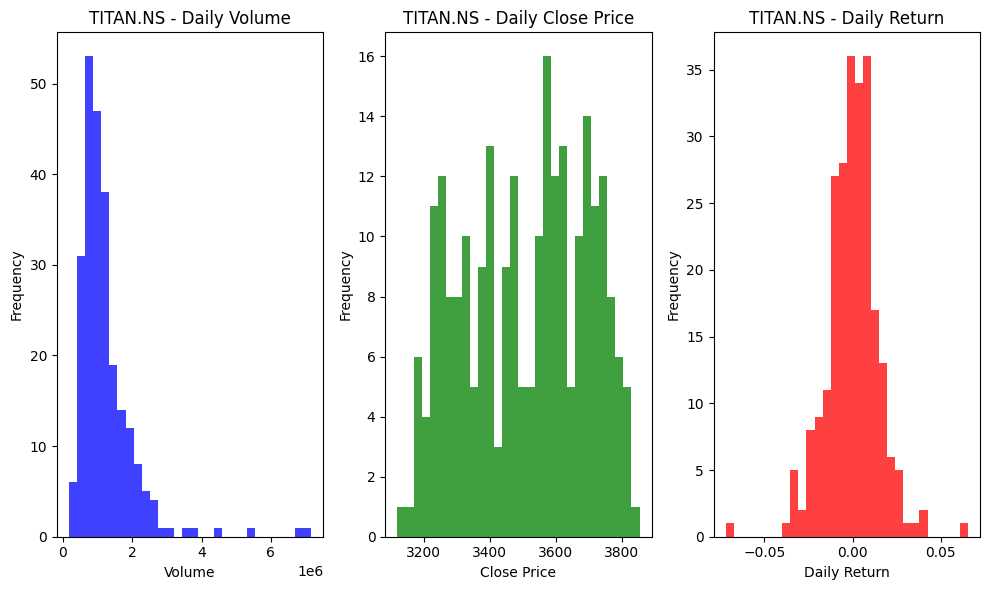

Results for TRENT.NS:
Z-Score: 0.15922250879208089
T-Score: 2.487135095380788
95% Confidence Interval: (0.0007863022489120052, 0.006773761432060802)


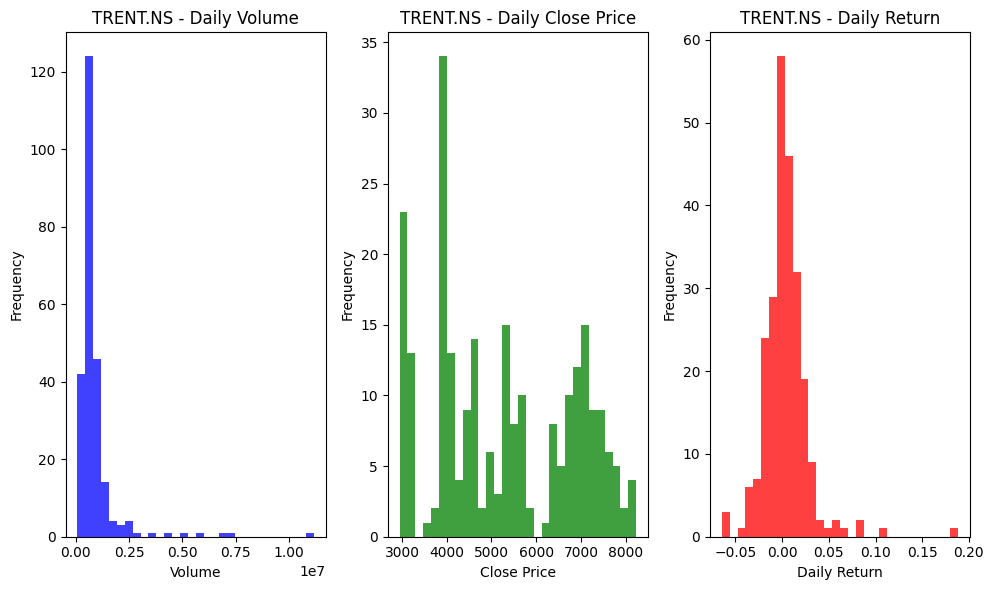

Results for ULTRACEMCO.NS:
Z-Score: 0.05717816343989323
T-Score: 0.8931514649507276
95% Confidence Interval: (-0.001020117969470318, 0.0027126694339888514)


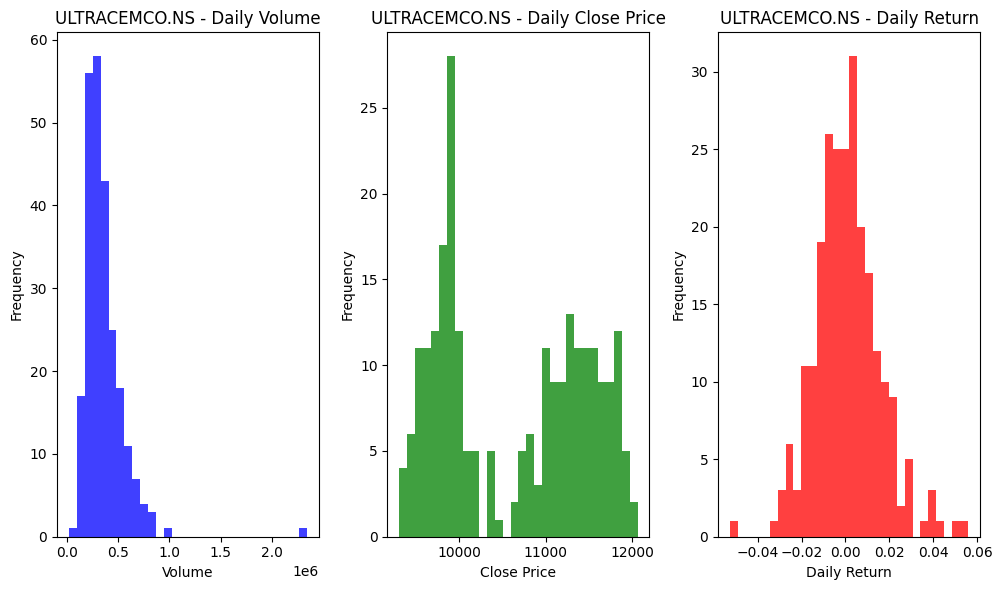

Results for WIPRO.NS:
Z-Score: 0.08965095238106845
T-Score: 1.4003926435579253
95% Confidence Interval: (-0.0006622705779803374, 0.003919975421544077)


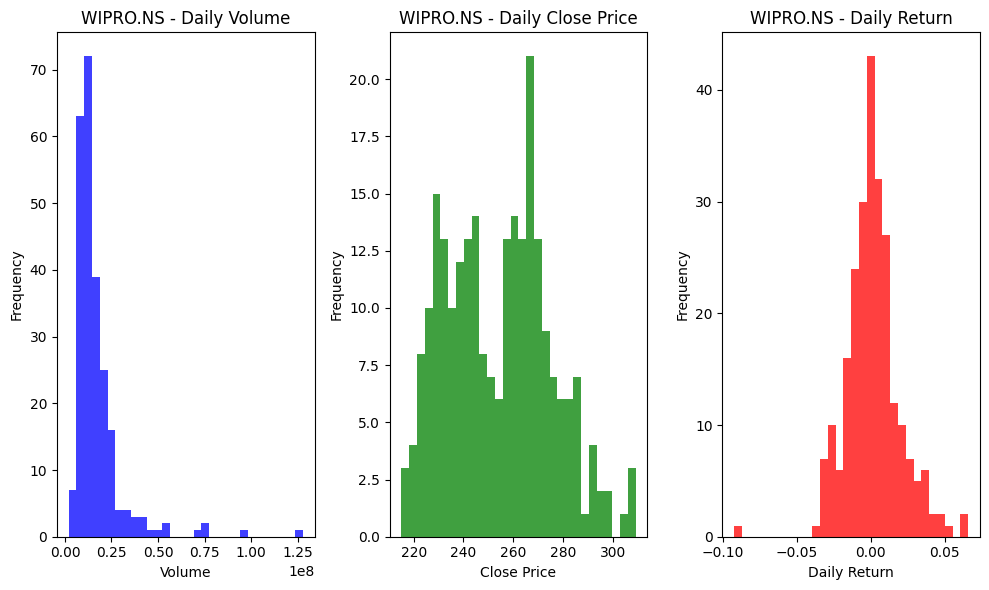

In [130]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def fetch_stock_data(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    return stock.history(start=start_date, end=end_date)

def calculate_daily_returns(data):
    data['Daily Return'] = data['Close'].pct_change()
    return data

def calculate_statistics(data):

    data = data.dropna()
    daily_returns = data['Daily Return']

    z_score = (daily_returns.mean() - 0) / daily_returns.std()
    t_score = (daily_returns.mean() - 0) / (daily_returns.std() / np.sqrt(len(daily_returns)))

    confidence_interval = stats.t.interval(0.95, len(daily_returns)-1, loc=daily_returns.mean(), scale=stats.sem(daily_returns))

    return z_score, t_score, confidence_interval

def plot_probability_distributions(data, symbol):

    plt.figure(figsize=(10, 6))

    plt.subplot(1, 3, 1)
    plt.hist(data['Volume'], bins=30, alpha=0.75, color='blue')
    plt.title(f'{symbol} - Daily Volume')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    plt.hist(data['Close'], bins=30, alpha=0.75, color='green')
    plt.title(f'{symbol} - Daily Close Price')
    plt.xlabel('Close Price')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.hist(data['Daily Return'], bins=30, alpha=0.75, color='red')
    plt.title(f'{symbol} - Daily Return')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def analyze_stock(symbol):
    today = datetime.today()

    start_date = today - timedelta(days=365)
    end_date = today

    data = fetch_stock_data(symbol, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))

    data = calculate_daily_returns(data)

    z_score, t_score, confidence_interval = calculate_statistics(data)

    print(f"Results for {symbol}:")
    print(f"Z-Score: {z_score}")
    print(f"T-Score: {t_score}")
    print(f"95% Confidence Interval: {confidence_interval}")

    plot_probability_distributions(data, symbol)

# Finally ho gya pura
for symbol in tickers:
    analyze_stock(symbol)
